In [ ]:
from google.colab import drive
from google.cloud import bigquery
import pandas as pd
import numpy as np
import glob
from sklearn.model_selection import train_test_split
import re
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/Capstone/

/content/drive/My Drive/Capstone


Load Sonoma Data

In [ ]:
import pandas as pd
import numpy as np

def load_Sonoma(params, name = 'Animal_Shelter_Intake_and_Outcome_20240517.csv'):
    '''
    this loads the csv, cleans the data and creates new columns

    name is the name of the csv, this should be a direct or relative path to the csv database for Animal_Shelter_Intake_and_Outcome

    params options

    na_data will fill missing data with 'unknown', delete missing data or do nothing
    input options are...
        * 'fill'
        * 'drop'
        * False

    drop_outlier_days removes pets who have a lenght of stay exceeding the value YOU enter
    input options are...
        * False
        * or any integer

    embed creates 50x1 embedding vectors for color and breed.
        download https://nlp.stanford.edu/data/glove.6B.zip, unzip and save in repo
        * True
        * False

    sample_dict controls stratified sampling
        * stratify_col: a column name used for stratified sampling... spelling and caps must be exact
        * train_size: a fraction of data you want for the training data
        * validate_size: a fraction of data you want for the validate data
        * test_size: a fraction of data you want for the test data

    num_buckets how many buckets to break up length of stay into for model training
        creates new column Days_in_Shelter_Label
        * input is a integer
    '''

    dtype_dict = {
        'Name': 'str',
        'Type': 'str',
        'Breed': 'str',
        'Color': 'str',
        'Sex': 'str',
        'Size': 'str',
        'Date Of Birth': 'str',
        'Intake Date': 'str',
        'Outcome Date': 'str',
        'Days in Shelter': 'int',
        'Impound Number': 'str',
        'Kennel Number': 'str',
        'Animal ID': 'str',
        'Outcome Type': 'str',
        'Outcome Subtype': 'str',
        'Intake Condition': 'str',
        'Outcome Condition': 'str',
        'Intake Jurisdiction': 'str',
        'Outcome Jurisdiction': 'str',
        'Outcome Zip Code': 'str',
        'Location': 'str',
        'Count': 'int'
    }
    df =  pd.read_csv(name, dtype=dtype_dict)
    df['Date Of Birth'].fillna('01/01/1900', inplace=True)
    # Convert 'Date Of Birth' to datetime after reading the CSV df['Date Of Birth'] = pd.to_datetime(df['Date Of Birth'], errors='coerce')
    df['Date Of Birth'] = pd.to_datetime(df['Date Of Birth'], errors='coerce')
    df['Intake Date'] = pd.to_datetime(df['Intake Date'], errors='coerce')
    df['Outcome Date'] = pd.to_datetime(df['Outcome Date'], errors='coerce')
    df = clean_df(df, params)
    df = feature_eng(df)

    return df

def feature_eng(df):
    '''this is where we add more columns'''

    # identify return animals, add new col for this
    df['Multiple_Visit_Count'] = df.groupby('Animal_ID')['Animal_ID'].transform('count')

    # calculate age at time of adoption
    df['Age_inDays_at_Income'] = (df['Intake_Date'] - df['Date_Of_Birth']).dt.days

    # Create age groups
    bins = [0, 1, 3, 10, 40, 1000]  # Example bins for age groups
    bins_days = [day*365 for day in bins]
    labels = ['Puppy/Kitten', 'Young', 'Adult', 'Senior', 'Unknown']
    df['Age_Group'] = pd.cut(df['Age_inDays_at_Income'], bins=bins_days, labels=labels)
    # df['Age_Group'].fillna('Unknown', inplace=True)

    # Example of feature interaction
    df['Is_Aggressive'] = df['Outcome_Subtype'].apply(lambda x: 1 if 'AGGRESSIVE' in str(x) else 0)

    # 1 if animal came to shelter with name, 0 f shelter named animal
    df['Has_Name'] = df['Name'].apply(lambda x: 0 if '*' in str(x) else 1)

    # 1 if animal is fixed, else 0
    df['Is_Fixed'] = df.Sex.apply(lambda x: 1 if 'NEUTERED' in str(x) or 'SPAYED' in str(x) else 0)
    # animal gender ignoring fix status
    df['Sex'] = df.Sex.apply(lambda x: 'MALE' if 'NEUTERED' in str(x) else str(x))
    df['Sex'] = df.Sex.apply(lambda x: 'FEMALE' if 'SPAYED' in str(x) else str(x))

    # are multiple breeds listed?
    df['Is_Mixed_Breed'] = df.Breed.apply(lambda x: 1 if '/' in str(x) or '&' in str(x) or 'MIX' in str(x) else 0)

    # are multiple breeds listed?
    df['Is_Multicolor'] = df.Color.apply(lambda x: 1 if '/' in str(x) else 0)

    return df

def clean_df(df, params):
    '''
    clean_df handles null data, renames columns to be more friendly in python, drops duplicates and more!


    params options
    na_data will fill missing data with 'unknown', delete missing data or do nothing
    input options are...
        * 'fill'
        * 'drop'
        * 'nothing'
    drop_outlier_days removes pets who have a lenght of stay exceeding the value YOU enter
    input options are...
        * False
        * or any integer
    '''

    # remove space from col name, force strings to upper
    col_list = []
    for col in df.columns:
        new_col = col.replace(' ', '_')
        col_list.append(new_col)
        try:
            df[col] = df[col].str.upper()
        except:
            print(f'{col} is NOT A STRING')
    df.columns = col_list

    # drop Other
    df = df[df.Type != 'OTHER']
    # remove animals without an outcome or intake date
    df = df[~df.Outcome_Date.isnull()]
    df = df[~df.Intake_Date.isnull()]
    # Remove duplicates
    df.drop_duplicates(inplace=True)
    # Drop rows where 'Animal ID' is missing as it is a critical identifier
    df.dropna(subset=['Animal_ID'], inplace=True)
    df.drop(columns=['Count'], inplace=True)
    # update TORTIE to Tortoiseshell
    df.loc[df.Color=='TORTIE', 'Color'] = 'Tortoiseshell'.upper()

    # place nan token for remaining columns
    for col in df.columns:
        null_count = df[col][df[col].isnull()].shape[0]
        if null_count!= 0 and params['na_data'] != False:
            if params['na_data'].lower() == 'fill':
                if (df[col].dtype != float and df[col].dtype != int):
                    print(f"replace null values in {col} with 'Unknown'")
                    df[col].fillna('Unknown', inplace=True)
                else:
                    print(f"replace null values in {col} with 'np.nan'")
                    df[col].fillna(np.nan, inplace=True)

            elif params['na_data'].lower() == 'drop':
                print(f"drop null values in {col}")
                df.dropna(subset=[col], inplace=True)

    if params['drop_outlier_days'] != False:
        df = df[df.Days_in_Shelter < int(params['drop_outlier_days'])]

    return df

if __name__ == '__main__':
    '''
    params options

    na_data will fill missing data with 'unknown', delete missing data or do nothing
    input options are...
        * 'fill'
        * 'drop'
        * False

    drop_outlier_days removes pets who have a lenght of stay exceeding the value YOU enter
    input options are...
        * False
        * or any integer

    embed creates 50x1 embedding vectors for color and breed
        download https://nlp.stanford.edu/data/glove.6B.zip, unzip and save in repo
        * True
        * False

    sample_dict controls stratified sampling
        * stratify_col: a column name used for stratified sampling... spelling and caps must be exact
        * train_size: a fraction of data you want for the training data
        * validate_size: a fraction of data you want for the validate data
        * test_size: a fraction of data you want for the test data

    num_buckets how many buckets to break up length of stay into for model training
        creates new column Days_in_Shelter_Label
        * input is a integer

    '''

    params = {
            'na_data': 'fill',
            'drop_outlier_days': 300,
            'embed':True,
            'num_buckets':3,
            'sample_dict':
                {
                'stratify_col':'Type',
                'train_size':0.6, 'validate_size':0.2, 'test_size':0.2
                }
            }
    df = load_Sonoma(params)

Date Of Birth is NOT A STRING
Intake Date is NOT A STRING
Outcome Date is NOT A STRING
Days in Shelter is NOT A STRING
Count is NOT A STRING
replace null values in Name with 'Unknown'
replace null values in Size with 'Unknown'
replace null values in Outcome_Type with 'Unknown'
replace null values in Outcome_Subtype with 'Unknown'
replace null values in Outcome_Condition with 'Unknown'
replace null values in Outcome_Jurisdiction with 'Unknown'
replace null values in Outcome_Zip_Code with 'Unknown'
replace null values in Location with 'Unknown'


CLEAN SONOMA DATASET

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


def load_df(params, name = 'Animal_Shelter_Intake_and_Outcome_20240517.csv'):
    '''
        params options

        na_data will fill missing data with 'unknown', delete missing data or do nothing
        input options are...
            * 'fill'
            * 'drop'
            * False

        drop_outlier_days removes pets who have a lenght of stay exceeding the value YOU enter
        input options are...
            * False
            * or any integer

        embed creates 50x1 embedding vectors for color and Subtype
            download https://nlp.stanford.edu/data/glove.6B.zip, unzip and save in repo
            * True
            * False

        sample_dict controls stratified sampling
            * stratify_col: a column name used for stratified sampling... spelling and caps must be exact
            * train_size: a fraction of data you want for the training data
            * validate_size: a fraction of data you want for the validate data
            * test_size: a fraction of data you want for the test data

        buckets what buckets will we split the data to?
            creates new column Days_in_Shelter_Label
            * input is a list of integers
            * please use [-1,3,14,30,100,99999999] as agreed upon based on shelter feedback
    '''
### REMOVE combine Sononma and Denver dataset step for EDA

    #df = load_Sonoma(params)
   # Sonoma_df['dataset'] = 'Sonoma'
   # denver_df = load_denver(params)
   # denver_df['dataset'] = 'Denver'
   # df = pd.concat([Sonoma_df,denver_df], ignore_index=True)


    # place nan token for remaining columns
    df = load_Sonoma(params)
    for col in df.columns:
        null_count = df[col][df[col].isnull()].shape[0]
        if null_count!= 0 and params['na_data'] != False:
            if params['na_data'].lower() == 'fill':
                if (df[col].dtype != float and df[col].dtype != int):
                    print(f"replace null values in {col} with 'Unknown'")
                    df[col].fillna('Unknown', inplace=True)
                else:
                    print(f"replace null values in {col} with 'np.nan'")
                    df[col].fillna(int(-1), inplace=True)

            elif params['na_data'].lower() == 'drop':
                print(f"drop null values in {col}")
                df.dropna(subset=[col], inplace=True)

    if params['embed']:
        # download https://nlp.stanford.edu/data/glove.6B.zip, unzip and save in repo
        glove_file_path = 'glove.6B.50d.txt'
        embeddings_index = load_glove_embeddings(glove_file_path)
        df = embed_colors(df, embeddings_index)
        df = embed_breeds(df, embeddings_index)
        df = embed_subtype(df, embeddings_index)

    class_labels = [i for i in range(len(params['buckets'])-1)]
    df['Days_in_Shelter_Label'] = pd.cut(df['Days_in_Shelter'], bins=params['buckets'], labels=class_labels)
    # df['Days_in_Shelter_Label'], bin_edges = pd.qcut(df['Days_in_Shelter'], q=num_buckets, labels=class_labels, retbins=True)
    train_df, validate_df, test_df = train_validate_test_split(df, params)

    return train_df, validate_df, test_df

def train_validate_test_split(df, params):
    '''split data into train, validate, test'''

    stratify_col = params['sample_dict']['stratify_col']
    train_size = params['sample_dict']['train_size']
    validate_size = params['sample_dict']['validate_size']
    test_size = params['sample_dict']['test_size']
    random_state = 42

    assert train_size + validate_size + test_size == 1, "Train, validate, and test sizes must sum to 1."

    # Split data into train+validate and test
    train_validate, test = train_test_split(df, test_size=test_size, stratify=df[stratify_col], random_state=random_state)

    # Calculate the proportion of validate
    validate_prop = validate_size / (train_size + validate_size)

    # Split train+validate into train and validate
    train, validate = train_test_split(train_validate, test_size=validate_prop, stratify=train_validate[stratify_col], random_state=random_state)

    return train, validate, test

def load_glove_embeddings(file_path='glove.6B.50d.txt'):
    embeddings_index = {}
    with open(file_path, encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

def get_word_embedding(word, embeddings_index):
    replace_dict = {
        'FLD':'field', 'HOSPTL':'hospital','CORONR':'coroner', 'HOSP':'hospital',
        'ABAND':'abandon', 'SHELT':'shelter', 'LIVSTK':'livestock','EUTH':'euthanasia',
        'HOUSELES':'homeless', 'PRIV':'Unknown','NONCONFIRM':'Unknown', 'SUBSTANC':'Unknown'
    }
    if word in replace_dict.keys():
        word = replace_dict[word]
    word = word.lower()
    return embeddings_index.get(word, np.zeros(50))  # 50 is the dimension of the GloVe vectors

def get_mean_color_embedding(color, color_embeddings):
    color = color.replace('/',' ')
    colors = color.split(' ')
    embeddings = [color_embeddings[c] for c in colors if c in color_embeddings]
    return np.mean(embeddings, axis=0)

def get_mean_breed_embedding(Subtype, breed_embeddings):
    Subtype = Subtype.replace('/',' ')
    Subtype = Subtype.replace('&',' ')
    Subtype = Subtype.replace('   ',' ')
    Subtype = Subtype.replace('  ',' ')
    breeds = Subtype.split(' ')
    embeddings = [breed_embeddings[c] for c in breeds if c in breed_embeddings]
    return np.mean(embeddings, axis=0)

def get_mean_subtype_embedding(Subtype, Subtype_embeddings):
    Subtype = Subtype.replace('-',' ')
    Subtype = Subtype.replace('_',' ')
    Subtype = Subtype.replace('   ',' ')
    Subtype = Subtype.replace('  ',' ')
    Subtypes = Subtype.split(' ')
    embeddings = [Subtype_embeddings[c] for c in Subtypes if c in Subtype_embeddings]
    return np.mean(embeddings, axis=0)

def embed_colors(df, embeddings_index):
    # Extract unique colors and get their embeddings
    unique_colors = df['Color'].str.replace('/', ' ').str.split(' ').explode().unique()
    color_embeddings = {color: get_word_embedding(color, embeddings_index) for color in unique_colors}
    if 'TORTIE' in color_embeddings.keys():
        color_embeddings['TORTIE'] = color_embeddings['Tortoiseshell'.upper()]
    # Apply the function to create embeddings for the 'Color' column
    df['Color_Embedding'] = df['Color'].apply(lambda x: get_mean_color_embedding(x, color_embeddings))
    # Perform PCA to reduce dimensionality to 2D
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(np.array(df.Color_Embedding.tolist()))
    # Apply KMeans clustering
    n_clusters = 5  # Define the number of clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df['Color_Embedding_Cluster'] = kmeans.fit_predict(reduced_embeddings)
    return df

def embed_breeds(df, embeddings_index):
    # Extract unique colors and get their embeddings
    unique_breeds = df['Breed'].str.replace('/',' ').str.replace('&',' ').str.split(' ').explode().unique()
    breed_embeddings = {breed: get_word_embedding(breed, embeddings_index) for breed in unique_breeds}
    df['Breed_Embedding'] = df['Breed'].apply(lambda x: get_mean_breed_embedding(x, breed_embeddings))
    # Perform PCA to reduce dimensionality to 2D
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(np.array(df.Breed_Embedding.tolist()))
    # Apply KMeans clustering
    n_clusters = 5  # Define the number of clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df['Breed_Embedding_Cluster'] = kmeans.fit_predict(reduced_embeddings)
    return df

def embed_subtype(df, embeddings_index):
    # Extract unique colors and get their embeddings
    unique_Subtype = df['Intake_Subtype'].str.replace('-',' ').str.replace('_',' ').str.split(' ').explode().unique()
    Subtype_embeddings = {Subtype: get_word_embedding(Subtype, embeddings_index) for Subtype in unique_Subtype}
    df['Intake_Subtype_Embedding'] = df['Intake_Subtype'].apply(lambda x: get_mean_subtype_embedding(x, Subtype_embeddings))
    # Perform PCA to reduce dimensionality to 2D
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(np.array(df.Intake_Subtype_Embedding.tolist()))
    # Apply KMeans clustering
    n_clusters = 5  # Define the number of clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df['Subtype_Embedding_Cluster'] = kmeans.fit_predict(reduced_embeddings)
    return df

def sklearn_pipeline(train_df,validate_df):
    # Define feature columns and target column
    feature_cols = ['Type', 'Sex', 'Size', 'Intake_Type', 'Intake_Subtype',
       'Intake_Condition', 'Multiple_Visit_Count',
       'Age_inDays_at_Income', 'Age_Group', 'Is_Aggressive', 'Has_Name',
       'Is_Fixed', 'Is_Mixed_Breed', 'Is_Multicolor', 'Color_Embedding_Cluster',
       'Breed_Embedding_Cluster']
    target_col = 'Days_in_Shelter_Label'

    # Split data into training and testing sets
    X_train = train_df[feature_cols]
    y_train = train_df[target_col]
    X_test = validate_df[feature_cols]
    y_test = validate_df[target_col]

    # Define the column transformer with OneHotEncoder for categorical columns and StandardScaler for numerical columns
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), ['Age_inDays_at_Income', 'Multiple_Visit_Count', 'Color_Embedding_Cluster',
                'Breed_Embedding_Cluster']),
            ('cat', OneHotEncoder(), ['Type', 'Sex', 'Size', 'Intake_Type', 'Intake_Subtype',
                'Intake_Condition','Age_Group', 'Is_Aggressive', 'Has_Name',
                'Is_Fixed', 'Is_Mixed_Breed', 'Is_Multicolor'])
        ])

    return preprocessor, X_train, y_train, X_test, y_test


if __name__ == '__main__':
    params = {
            'na_data': 'fill',
            'drop_outlier_days': 300,
            'embed':True,
            'buckets':[-1,3,14,30,100,99999999],
            'sample_dict':
                {
                'stratify_col':'Type',
                'train_size':0.6, 'validate_size':0.2, 'test_size':0.2
                }
            }
    train_df, validate_df, test_df = load_df(params)

Date Of Birth is NOT A STRING
Intake Date is NOT A STRING
Outcome Date is NOT A STRING
Days in Shelter is NOT A STRING
Count is NOT A STRING
replace null values in Name with 'Unknown'
replace null values in Size with 'Unknown'
replace null values in Outcome_Type with 'Unknown'
replace null values in Outcome_Subtype with 'Unknown'
replace null values in Outcome_Condition with 'Unknown'
replace null values in Outcome_Jurisdiction with 'Unknown'
replace null values in Outcome_Zip_Code with 'Unknown'
replace null values in Location with 'Unknown'
replace null values in Age_Group with 'Unknown'


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
df = pd.concat([train_df, validate_df, test_df], ignore_index=True) # do this if you want to look at all the data still

In [ ]:
df.head(100)

,Name,Type,Breed,Color,Sex,Size,Date_Of_Birth,Impound_Number,Kennel_Number,Animal_ID,...,Is_Fixed,Is_Mixed_Breed,Is_Multicolor,Color_Embedding,Color_Embedding_Cluster,Breed_Embedding,Breed_Embedding_Cluster,Intake_Subtype_Embedding,Subtype_Embedding_Cluster,Days_in_Shelter_Label
0,BLUE,DOG,PIT BULL,BLACK/WHITE,MALE,PUPPY,2014-11-21,K15-016875,DS64,A329815,...,1,0,1,"[-0.82454, 0.72727, -0.58195996, -0.280925, 0....",2,"[0.095295, 0.0053056004, -0.11658999, -0.14415...",2,"[-0.49284, 0.3731, 0.15565, 0.70044, 0.77405, ...",0,0
1,Unknown,DOG,CHIHUAHUA SH,TAN/WHITE,FEMALE,SMALL,2011-09-11,K23-046033,DA23,A420326,...,0,0,1,"[-0.52346, 0.562445, -0.68111503, 0.399905, 0....",3,"[0.130645, -0.560145, 0.16823497, 0.5767175, -...",0,"[-0.49284, 0.3731, 0.15565, 0.70044, 0.77405, ...",0,1
2,*MIKEY,CAT,DOMESTIC SH,BRN TABBY/WHITE,MALE,KITTN,2019-05-30,K19-033266,LOBBY,A390288,...,1,0,1,"[-0.49960002, 0.17075665, -0.041086674, 0.4830...",0,"[-0.2414185, -0.09857, 0.601084, 0.1138925, -0...",1,"[0.26741, -0.26734897, -0.10547667, -0.0549793...",1,2
3,*KODA,DOG,MIN PINSCHER,RED,FEMALE,SMALL,2003-12-10,K14-007233,DA02,A300443,...,1,0,0,"[-0.12878, 0.8798, -0.60694, 0.12934, 0.5868, ...",2,"[-0.86184, 0.64402, 0.53236, -0.24103001, 0.01...",4,"[0.26741, -0.26734897, -0.10547667, -0.0549793...",1,0
4,COOPER,CAT,DOMESTIC SH,BLACK,MALE,KITTN,2015-05-10,K15-014101,LOBBY,A322340,...,1,0,0,"[-0.96256, 0.65329, -0.55152, -0.41065, 0.8022...",2,"[-0.2414185, -0.09857, 0.601084, 0.1138925, -0...",1,"[0.26741, -0.26734897, -0.10547667, -0.0549793...",1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,LOLA,DOG,LABRADOR RETR,BLACK,FEMALE,MED,2013-10-25,K14-010896,DA29,A310001,...,1,0,0,"[-0.96256, 0.65329, -0.55152, -0.41065, 0.8022...",2,"[0.12737999856472015, 0.0017187000485137105, -...",4,"[-0.49284, 0.3731, 0.15565, 0.70044, 0.77405, ...",0,1
96,Unknown,DOG,JINDO/MIX,WHITE,MALE,MED,1900-01-01,K17-022941,DQ112,A350285,...,0,1,0,"[-0.68652, 0.80125, -0.6124, -0.1512, 0.997, 0...",2,"[-0.17439501, -0.2860735, -0.58380497, 0.48670...",3,"[0.26741, -0.26734897, -0.10547667, -0.0549793...",1,1
97,SPOT,CAT,DOMESTIC SH,WHITE/BRN TABBY,MALE,SMALL,2016-04-04,K16-021024,CS05,A343186,...,1,0,1,"[-0.49960002, 0.17075665, -0.041086674, 0.4830...",0,"[-0.2414185, -0.09857, 0.601084, 0.1138925, -0...",1,"[0.26741, -0.26734897, -0.10547667, -0.0549793...",1,0
98,*MISSY,DOG,QUEENSLAND HEEL/SIBERIAN HUSKY,WHITE/BLACK,FEMALE,MED,2015-04-04,K17-022926,KINGS KSTL,A349983,...,1,1,1,"[-0.82454, 0.72727, -0.58195996, -0.280925, 0....",2,"[-0.53197825, -0.116084754, -0.44044825, 0.262...",4,"[-0.49284, 0.3731, 0.15565, 0.70044, 0.77405, ...",0,3


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25235 entries, 0 to 25234
Data columns (total 38 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Name                       25235 non-null  object        
 1   Type                       25235 non-null  object        
 2   Breed                      25235 non-null  object        
 3   Color                      25235 non-null  object        
 4   Sex                        25235 non-null  object        
 5   Size                       25235 non-null  object        
 6   Date_Of_Birth              25235 non-null  datetime64[ns]
 7   Impound_Number             25235 non-null  object        
 8   Kennel_Number              25235 non-null  object        
 9   Animal_ID                  25235 non-null  object        
 10  Intake_Date                25235 non-null  datetime64[ns]
 11  Outcome_Date               25235 non-null  datetime64[ns]
 12  Days

# **EDA: Shelter Animal Attributes by Days in Shelter Label**

Days in Shelter Label Observations Summary

Record Count

*   Label 0 has the most records (9362)
*   Label 4 has the least records (477)
*   Labels 1-3 are relatatively similar in record volume (min: 4398, max: 6327)

Generally, Label 0 and 4 are the most different than the other labels. Labels 1-3 are similar. Label 4 is the most unique.

Adding Days in shelter label as a factor may help improve the model accuracy.

Re-generating days in shelter labels for similar bin sizes may cause observations to change


In [ ]:
df.Days_in_Shelter_Label.value_counts()

Days_in_Shelter_Label
0    9362
1    6327
2    4671
3    4398
4     477
Name: count, dtype: int64

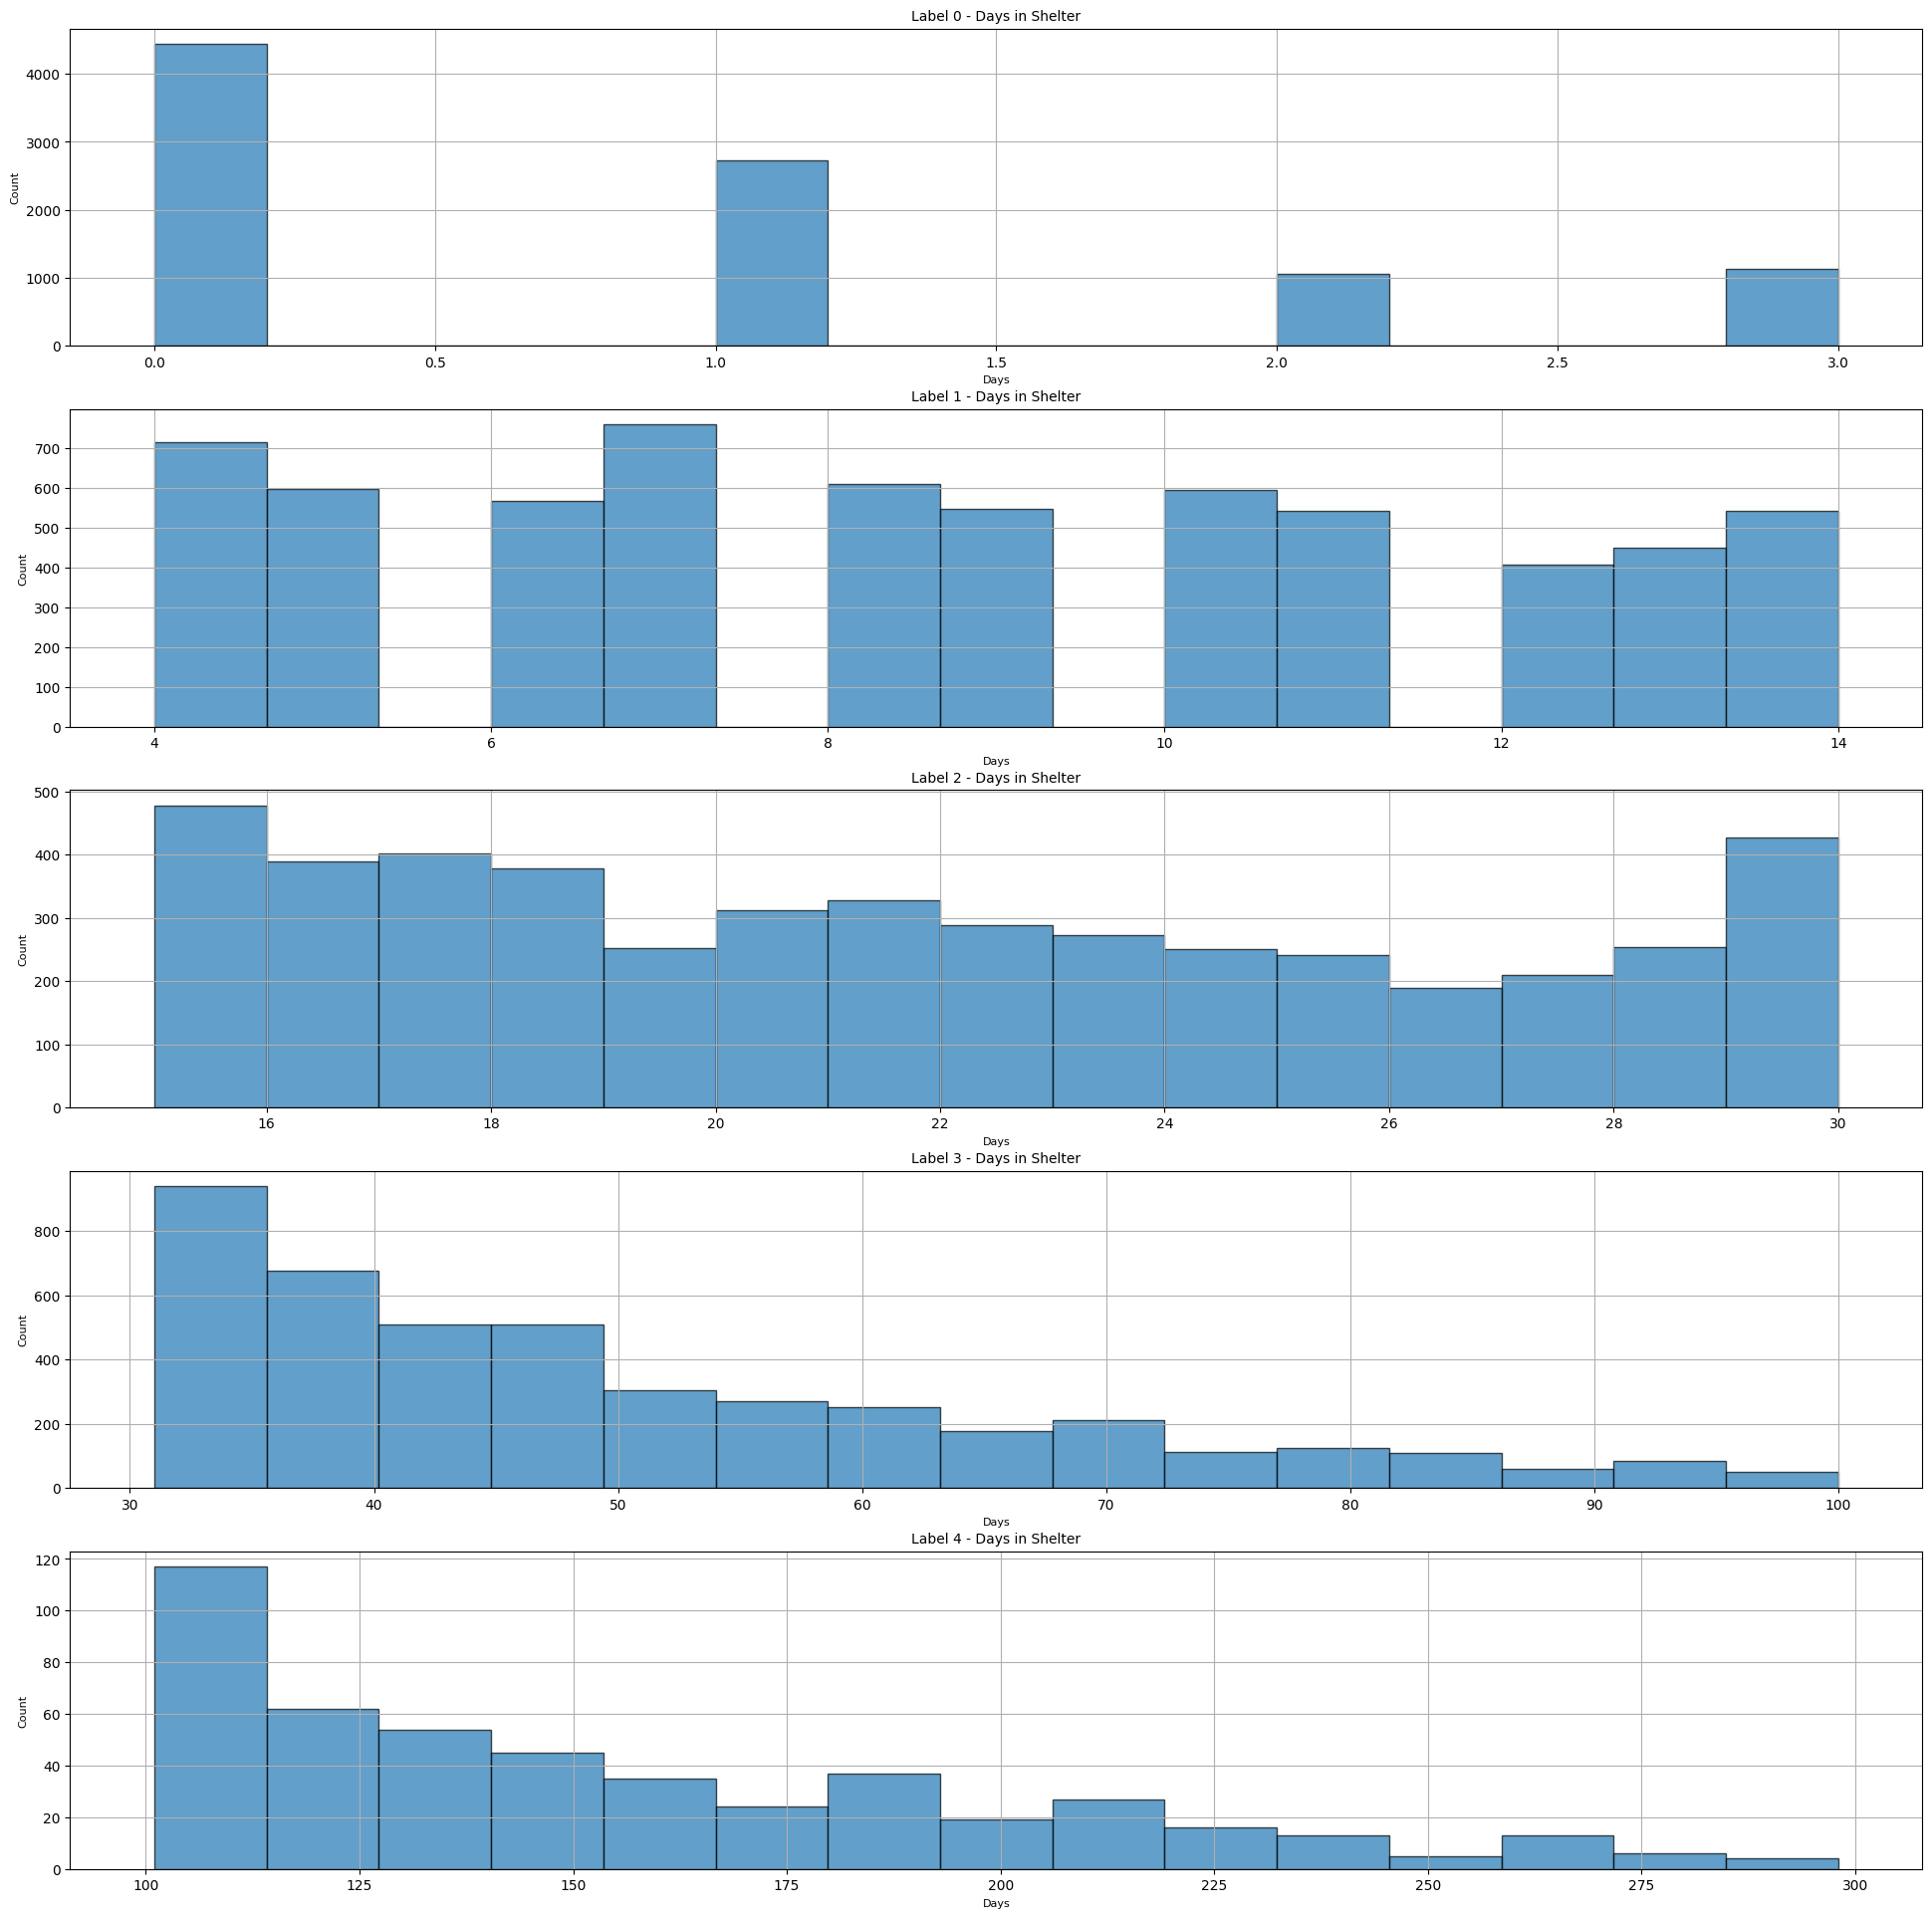

In [ ]:
# Separate df by Days in Shelter Label
df_0 = df[(df['Days_in_Shelter_Label'] == 0)]
df_1 = df[(df['Days_in_Shelter_Label'] == 1)]
df_2 = df[(df['Days_in_Shelter_Label'] == 2)]
df_3 = df[(df['Days_in_Shelter_Label'] == 3)]
df_4 = df[(df['Days_in_Shelter_Label'] == 4)]


# Plot the log-transformed length of stay for Days in Shelter Label 0
plt.figure(figsize=(24, 24))

plt.subplot(5, 1, 1)
plt.hist(df_0['Days_in_Shelter'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Label 0 - Days in Shelter', fontsize=10)
plt.xlabel('Days', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)

# Plot the log-transformed length of stay for Days in Shelter Label 1
plt.subplot(5, 1, 2)
plt.hist(df_1['Days_in_Shelter'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Label 1 - Days in Shelter', fontsize=10)
plt.xlabel('Days', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)

# Plot the log-transformed length of stay for Days in Shelter Label 2
plt.subplot(5, 1, 3)
plt.hist(df_2['Days_in_Shelter'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Label 2 - Days in Shelter', fontsize=10)
plt.xlabel('Days', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)

# Plot the log-transformed length of stay for Days in Shelter Label 3
plt.subplot(5, 1, 4)
plt.hist(df_3['Days_in_Shelter'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Label 3 - Days in Shelter', fontsize=10)
plt.xlabel('Days', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)

# Plot the log-transformed length of stay for Days in Shelter Label 4
plt.subplot(5, 1, 5)
plt.hist(df_4['Days_in_Shelter'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Label 4 - Days in Shelter', fontsize=10)
plt.xlabel('Days', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)

Outcome Type Observations


*   Animals who are returned to owners are often at the shelter for fewer days
*   Days in shetler label bins 0-1 have a higher porportion of return to owner outcome types than days in shelter label bins 2-4
*   Very few return to owner records exist in label bins 2 - 4
*   Adoption is the most frequent outcome for label bins 2 - 4




<Axes: xlabel='Days_in_Shelter_Label'>

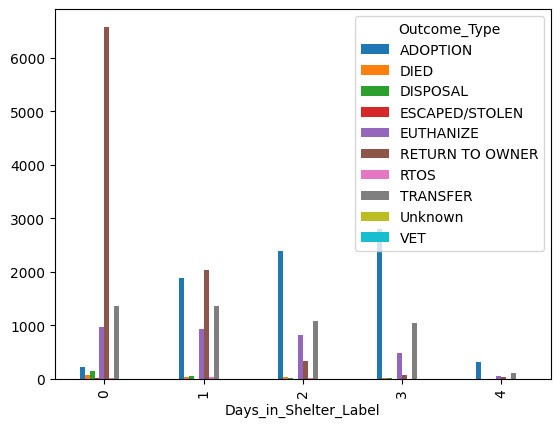

In [ ]:
df.groupby('Outcome_Type').Days_in_Shelter_Label.value_counts().unstack(0).plot.bar()

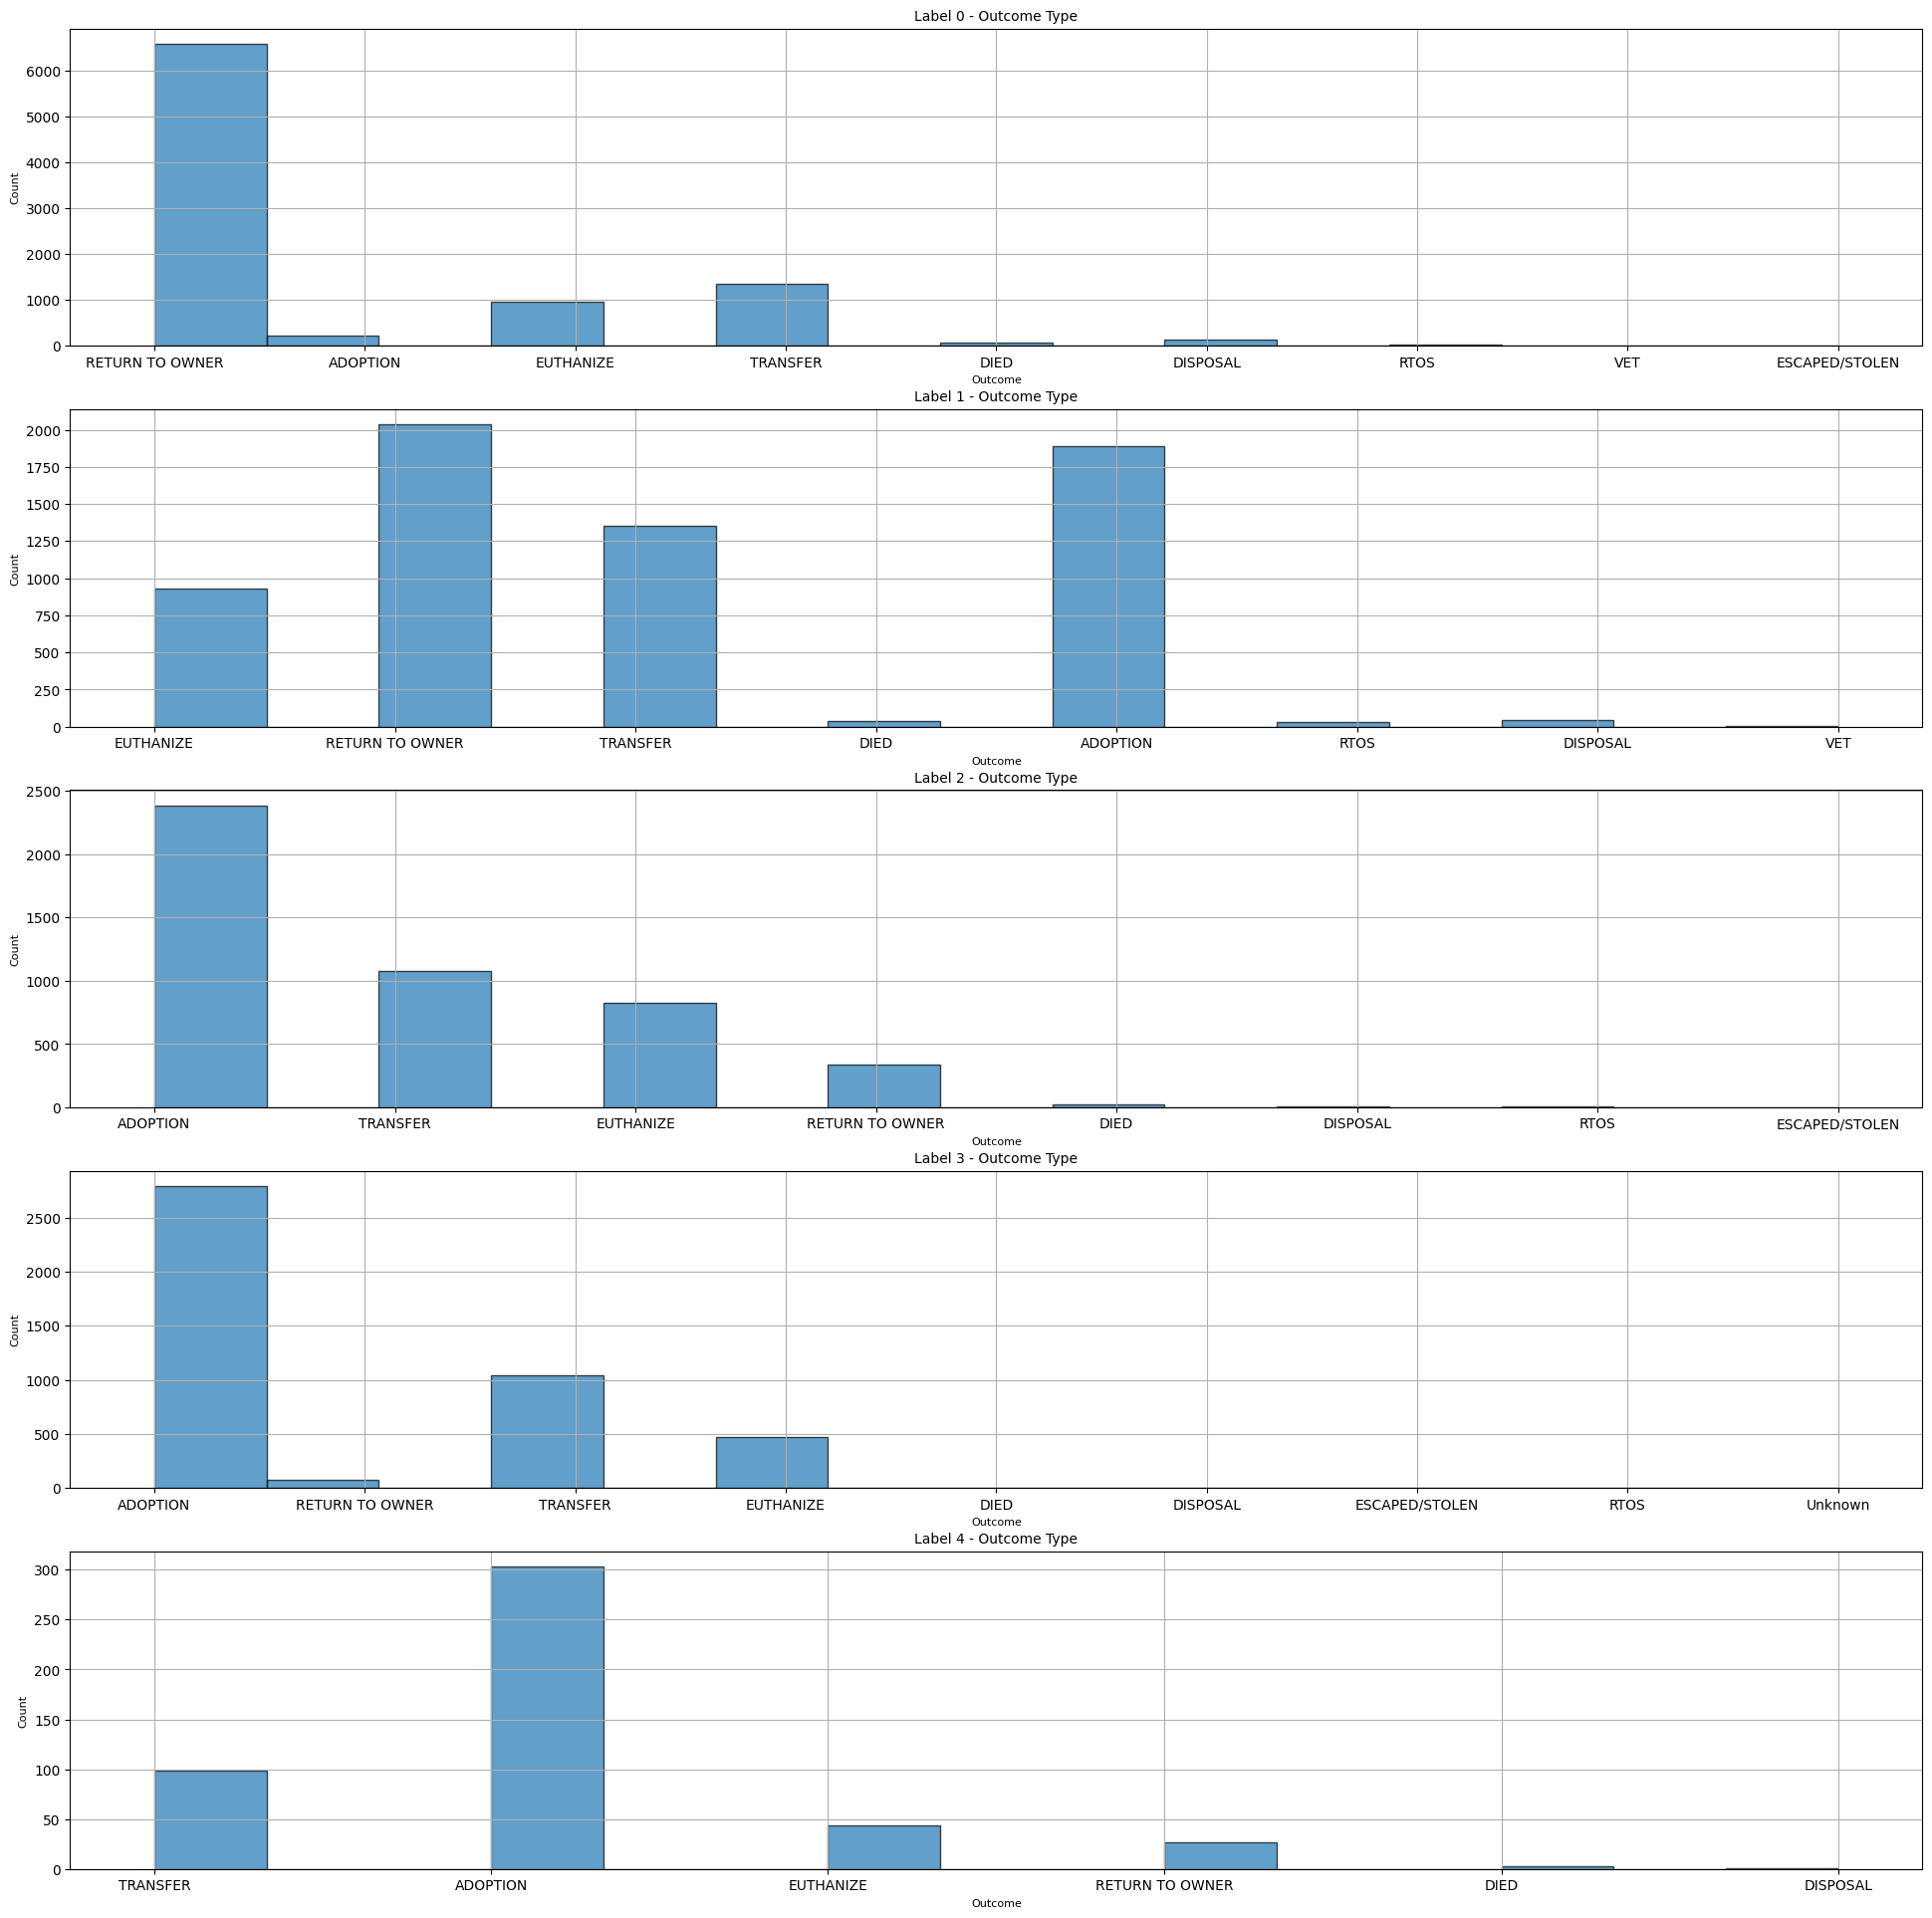

In [ ]:
# Separate df by Days in Shelter Label
df_0 = df[(df['Days_in_Shelter_Label'] == 0)]
df_1 = df[(df['Days_in_Shelter_Label'] == 1)]
df_2 = df[(df['Days_in_Shelter_Label'] == 2)]
df_3 = df[(df['Days_in_Shelter_Label'] == 3)]
df_4 = df[(df['Days_in_Shelter_Label'] == 4)]

# Plot the Outcome Type distribution for Days in Shelter Label 0
plt.figure(figsize=(24, 24))

plt.subplot(5, 1, 1)
plt.hist(df_0['Outcome_Type'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Label 0 - Outcome Type', fontsize=10)
plt.xlabel('Outcome', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)

# Plot the Outcome Type distribution for Days in Shelter Label 1
plt.subplot(5, 1, 2)
plt.hist(df_1['Outcome_Type'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Label 1 - Outcome Type', fontsize=10)
plt.xlabel('Outcome', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)

# Plot the Outcome Type distribution for Days in Shelter Label 2
plt.subplot(5, 1, 3)
plt.hist(df_2['Outcome_Type'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Label 2 - Outcome Type', fontsize=10)
plt.xlabel('Outcome', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)

# Plot the Outcome Type distribution for Days in Shelter Label 3
plt.subplot(5, 1, 4)
plt.hist(df_3['Outcome_Type'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Label 3 - Outcome Type', fontsize=10)
plt.xlabel('Outcome', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)

# Plot the Outcome Type distribution for Days in Shelter Label 4
plt.subplot(5, 1, 5)
plt.hist(df_4['Outcome_Type'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Label 4 - Outcome Type', fontsize=10)
plt.xlabel('Outcome', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)

Aggression Observations

*   Aggressive animals are infrequent in Days in Shelter Labels 0 and 4
*   Aggressive animals are similarily representated in Days in Shelter Labels 1-3
*   In generally, agressiveness is rare



<Axes: xlabel='Days_in_Shelter_Label'>

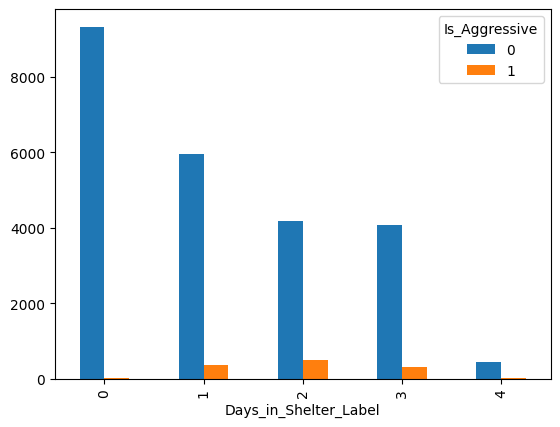

In [ ]:
df.groupby('Is_Aggressive').Days_in_Shelter_Label.value_counts().unstack(0).plot.bar()

Spayed/Neutred Observations

*   Days in shelter label 0 has a relatively balance split between fixed and not fixed animals
*   not fixed animals decline as days in shelter label number increases
*   Fixed is the most common status for animals in days in shelter labels 1-4.
*   Not fixed is the most common status for animals in days in shelter label 0

<Axes: xlabel='Days_in_Shelter_Label'>

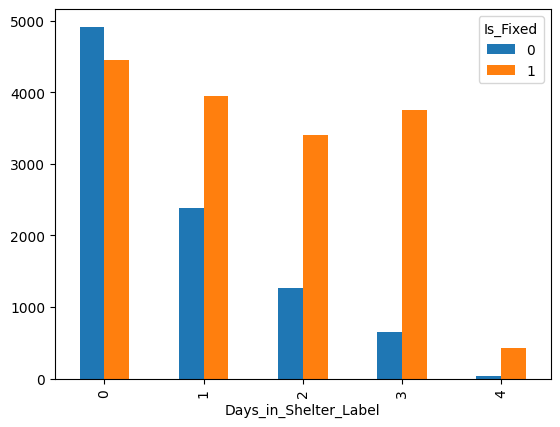

In [ ]:
df.groupby('Is_Fixed').Days_in_Shelter_Label.value_counts().unstack(0).plot.bar()

Multicolor Observations

*   Multicolor status is relatively balanced across all days in shelter labels.
*   Not multicolor is slightly more frequent in days in shelter labels 0-1



<Axes: xlabel='Days_in_Shelter_Label'>

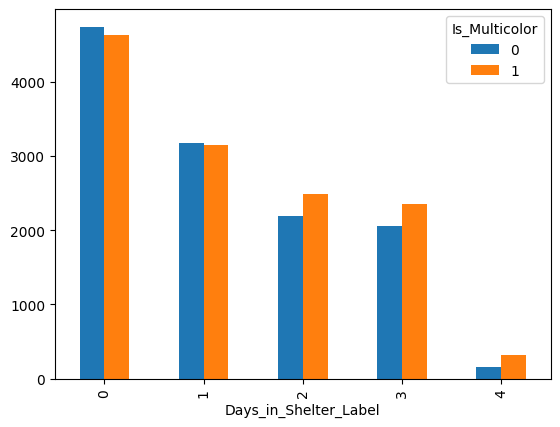

In [ ]:
df.groupby('Is_Multicolor').Days_in_Shelter_Label.value_counts().unstack(0).plot.bar()

Mixed Breed Observations

*   Pure breed is more common than mixed breed across all days in shelter labels
*   Mixed breed becomes make up a higher proportion as days in shelter label number increases



<Axes: xlabel='Days_in_Shelter_Label'>

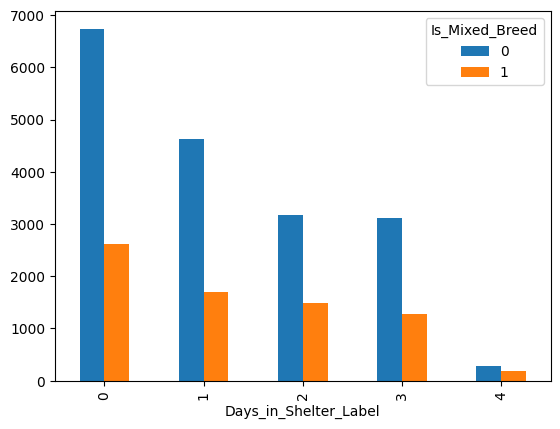

In [ ]:
df.groupby('Is_Mixed_Breed').Days_in_Shelter_Label.value_counts().unstack(0).plot.bar()

Sex Observations

*   Sex is fairly balanced across all days in shelter labels
*   Male is more likely than Female across all days in shelter labels
*   Unknown population decreases as days in shelter label number increases



<Axes: xlabel='Days_in_Shelter_Label'>

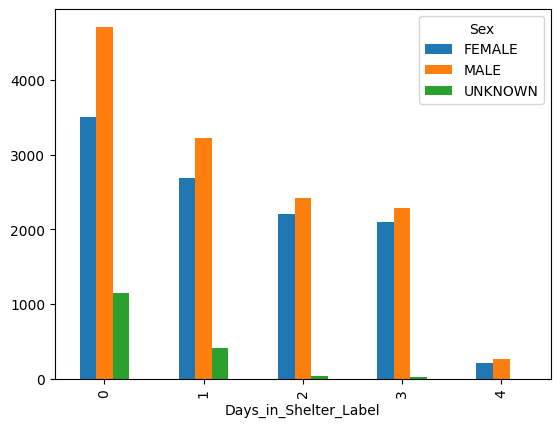

In [ ]:
df.groupby('Sex').Days_in_Shelter_Label.value_counts().unstack(0).plot.bar()

Color Cluster Observations

*   Color clusters are similarly distributed across all days in shelter labels
*   Color cluster 2 is the most frequent cluster across all days in shelter labels



<Axes: xlabel='Days_in_Shelter_Label'>

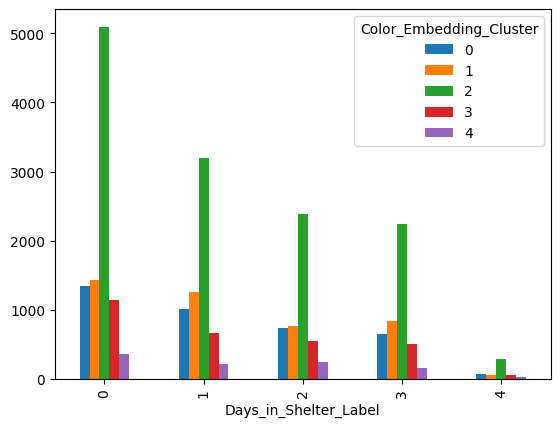

In [ ]:
df.groupby('Color_Embedding_Cluster').Days_in_Shelter_Label.value_counts().unstack(0).plot.bar()

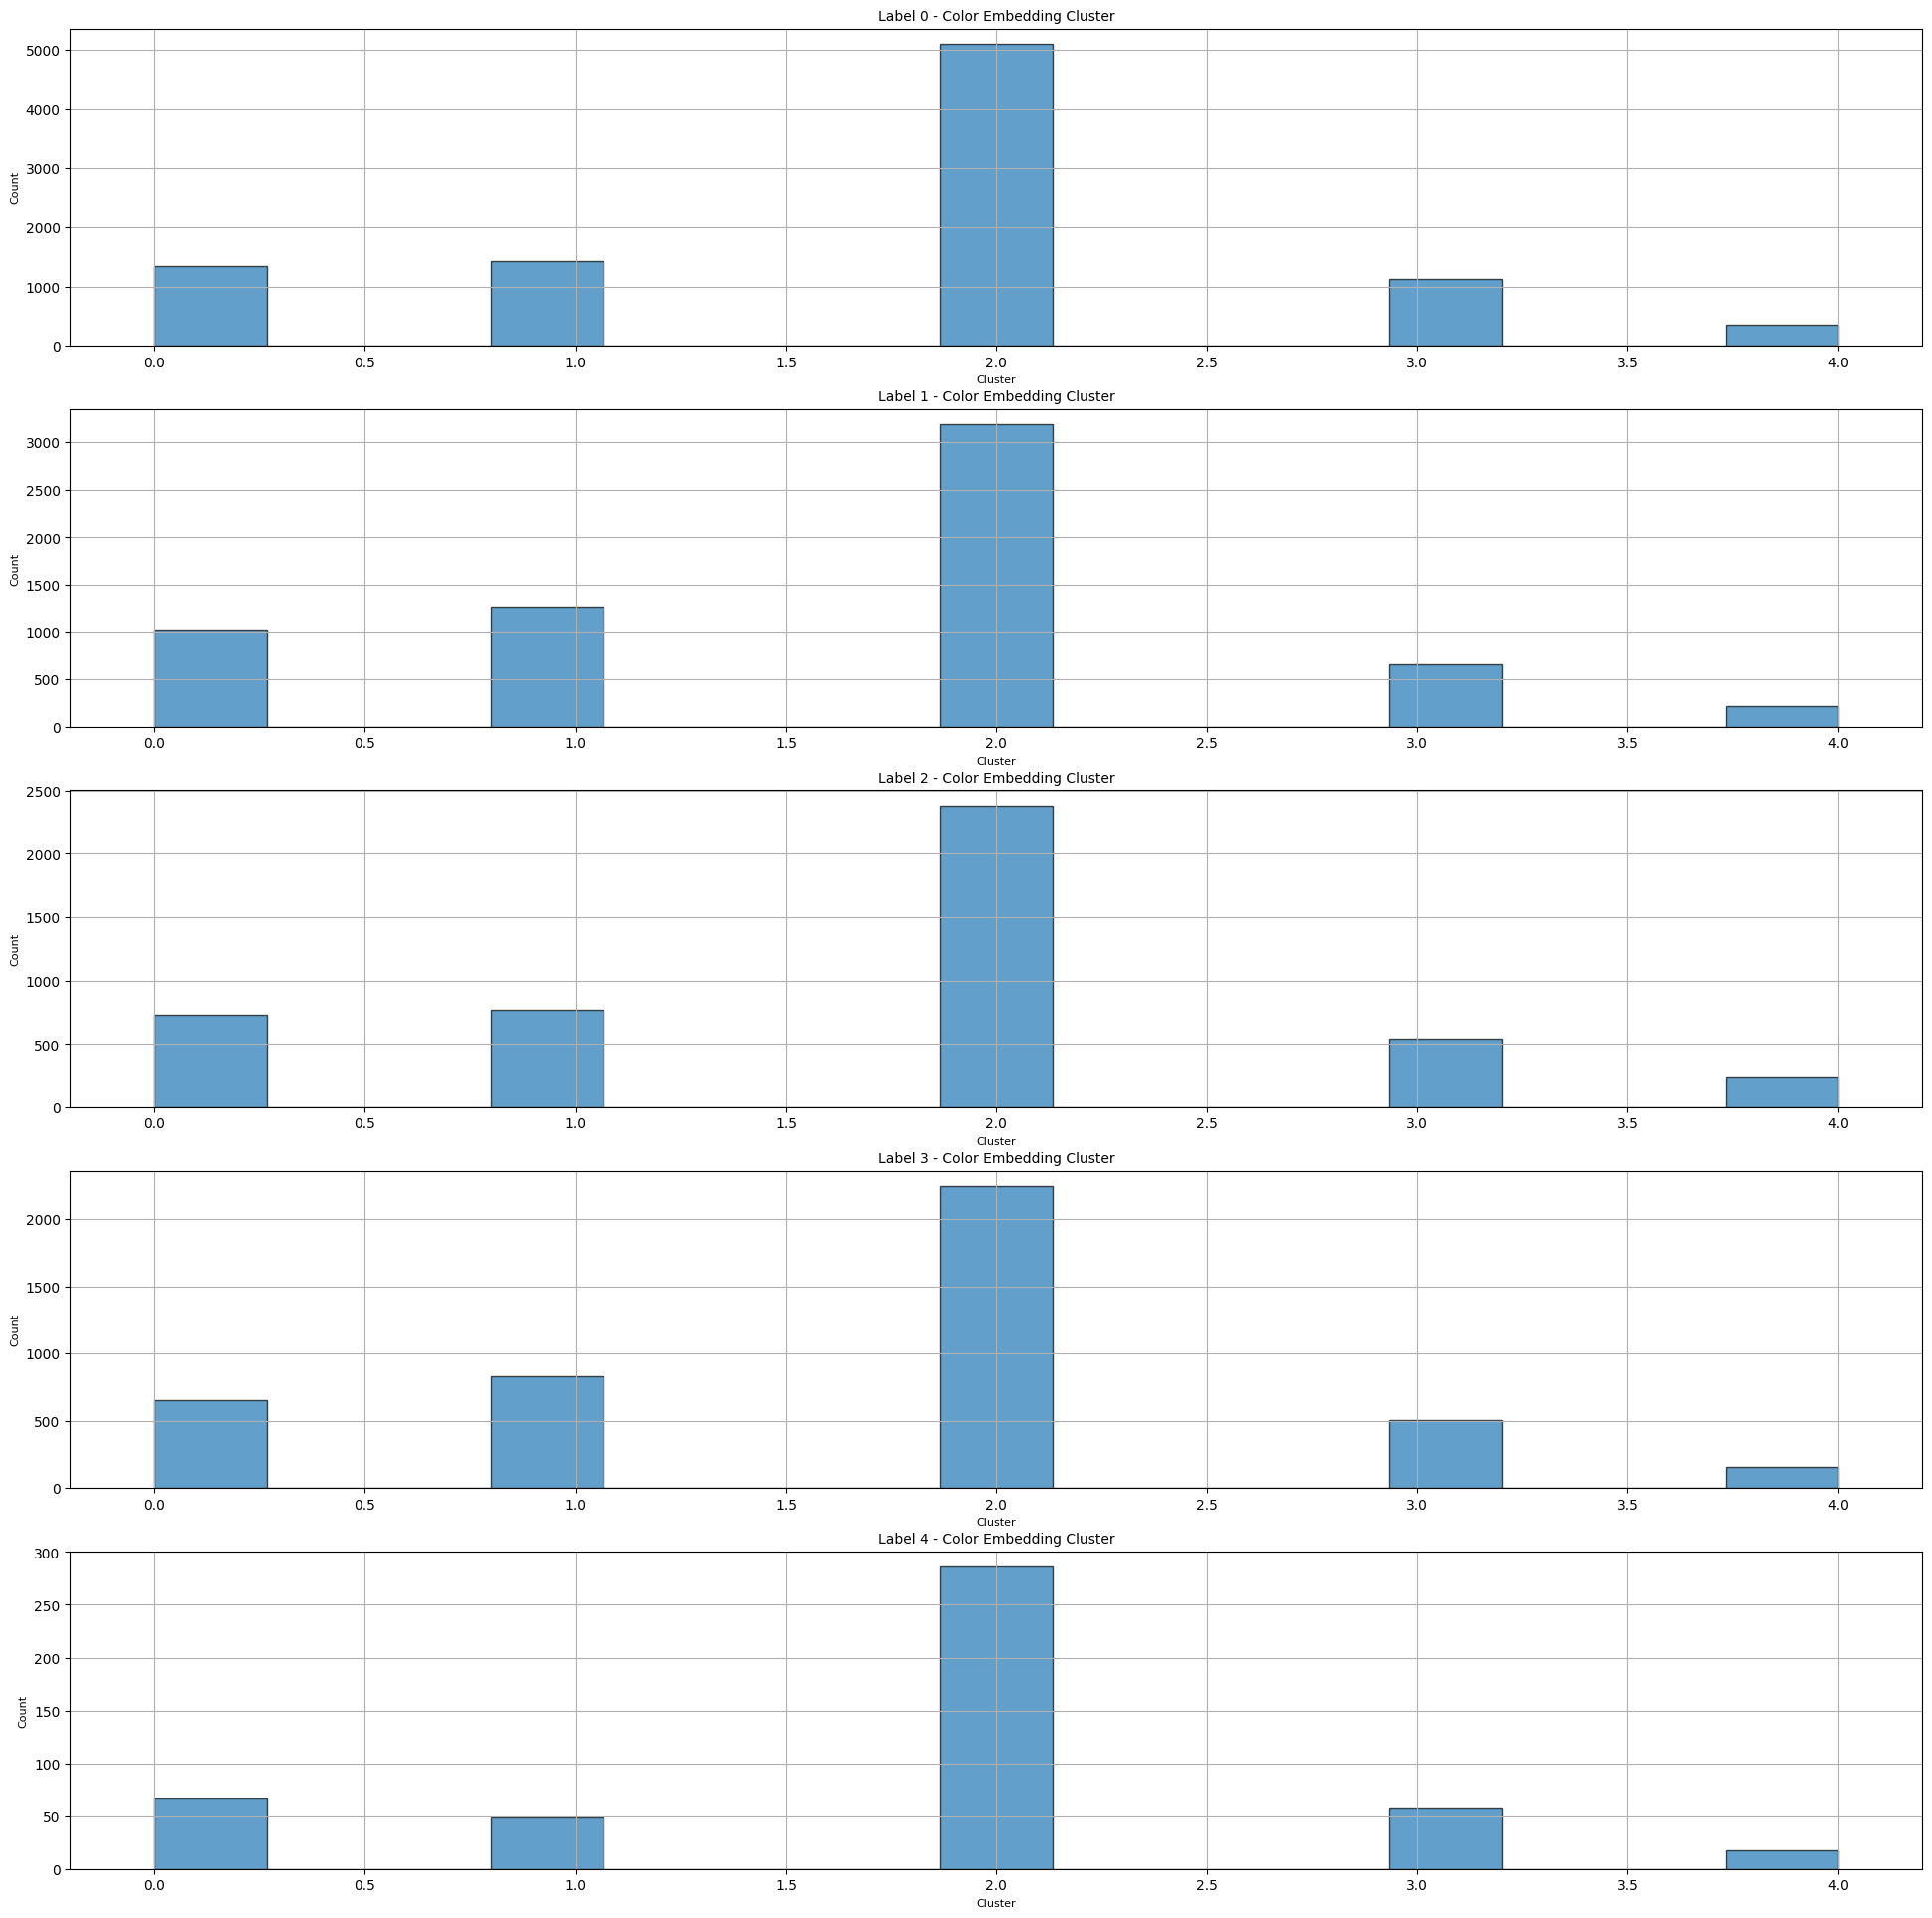

In [ ]:
# Separate df by Days in Shelter Label
df_0 = df[(df['Days_in_Shelter_Label'] == 0)]
df_1 = df[(df['Days_in_Shelter_Label'] == 1)]
df_2 = df[(df['Days_in_Shelter_Label'] == 2)]
df_3 = df[(df['Days_in_Shelter_Label'] == 3)]
df_4 = df[(df['Days_in_Shelter_Label'] == 4)]

# Plot the Age Group distribution for Days in Shelter Label 0
plt.figure(figsize=(24, 24))

plt.subplot(5, 1, 1)
plt.hist(df_0['Color_Embedding_Cluster'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Label 0 - Color Embedding Cluster', fontsize=10)
plt.xlabel('Cluster', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)

# Plot the Age Group distribution for Days in Shelter Label 1
plt.subplot(5, 1, 2)
plt.hist(df_1['Color_Embedding_Cluster'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Label 1 - Color Embedding Cluster', fontsize=10)
plt.xlabel('Cluster', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)

# Plot the Age Group distribution for Days in Shelter Label 2
plt.subplot(5, 1, 3)
plt.hist(df_2['Color_Embedding_Cluster'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Label 2 - Color Embedding Cluster', fontsize=10)
plt.xlabel('Cluster', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)

# Plot the Age Group distribution for Days in Shelter Label 3
plt.subplot(5, 1, 4)
plt.hist(df_3['Color_Embedding_Cluster'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Label 3 - Color Embedding Cluster', fontsize=10)
plt.xlabel('Cluster', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)

# Plot the Age Group distribution for Days in Shelter Label 4
plt.subplot(5, 1, 5)
plt.hist(df_4['Color_Embedding_Cluster'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Label 4 - Color Embedding Cluster', fontsize=10)
plt.xlabel('Cluster', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)

Breed Cluster Observations

*   Breed clusters are similarly distributed for days in shelter labels 0-3
*   Breed cluster 1 is the most frequent cluster for days in shelter labels 0-3. Cluster 3 is the second mos frequent. Cluster 0 is the least frequent.
*   Breed cluster 2 is the most frequent cluster for days in shelter label 4. Cluster 3 is the second most frequent. Cluster 0 is the least frequent

<Axes: xlabel='Days_in_Shelter_Label'>

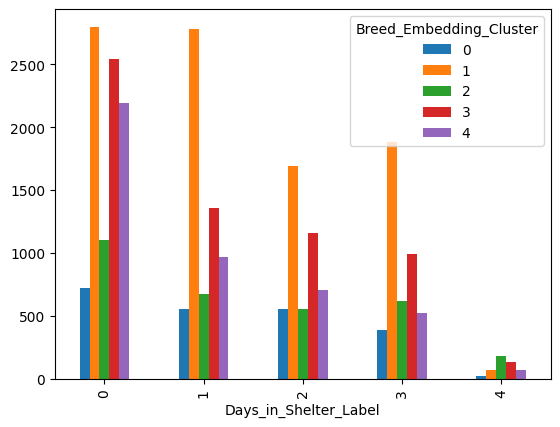

In [ ]:
df.groupby('Breed_Embedding_Cluster').Days_in_Shelter_Label.value_counts().unstack(0).plot.bar()

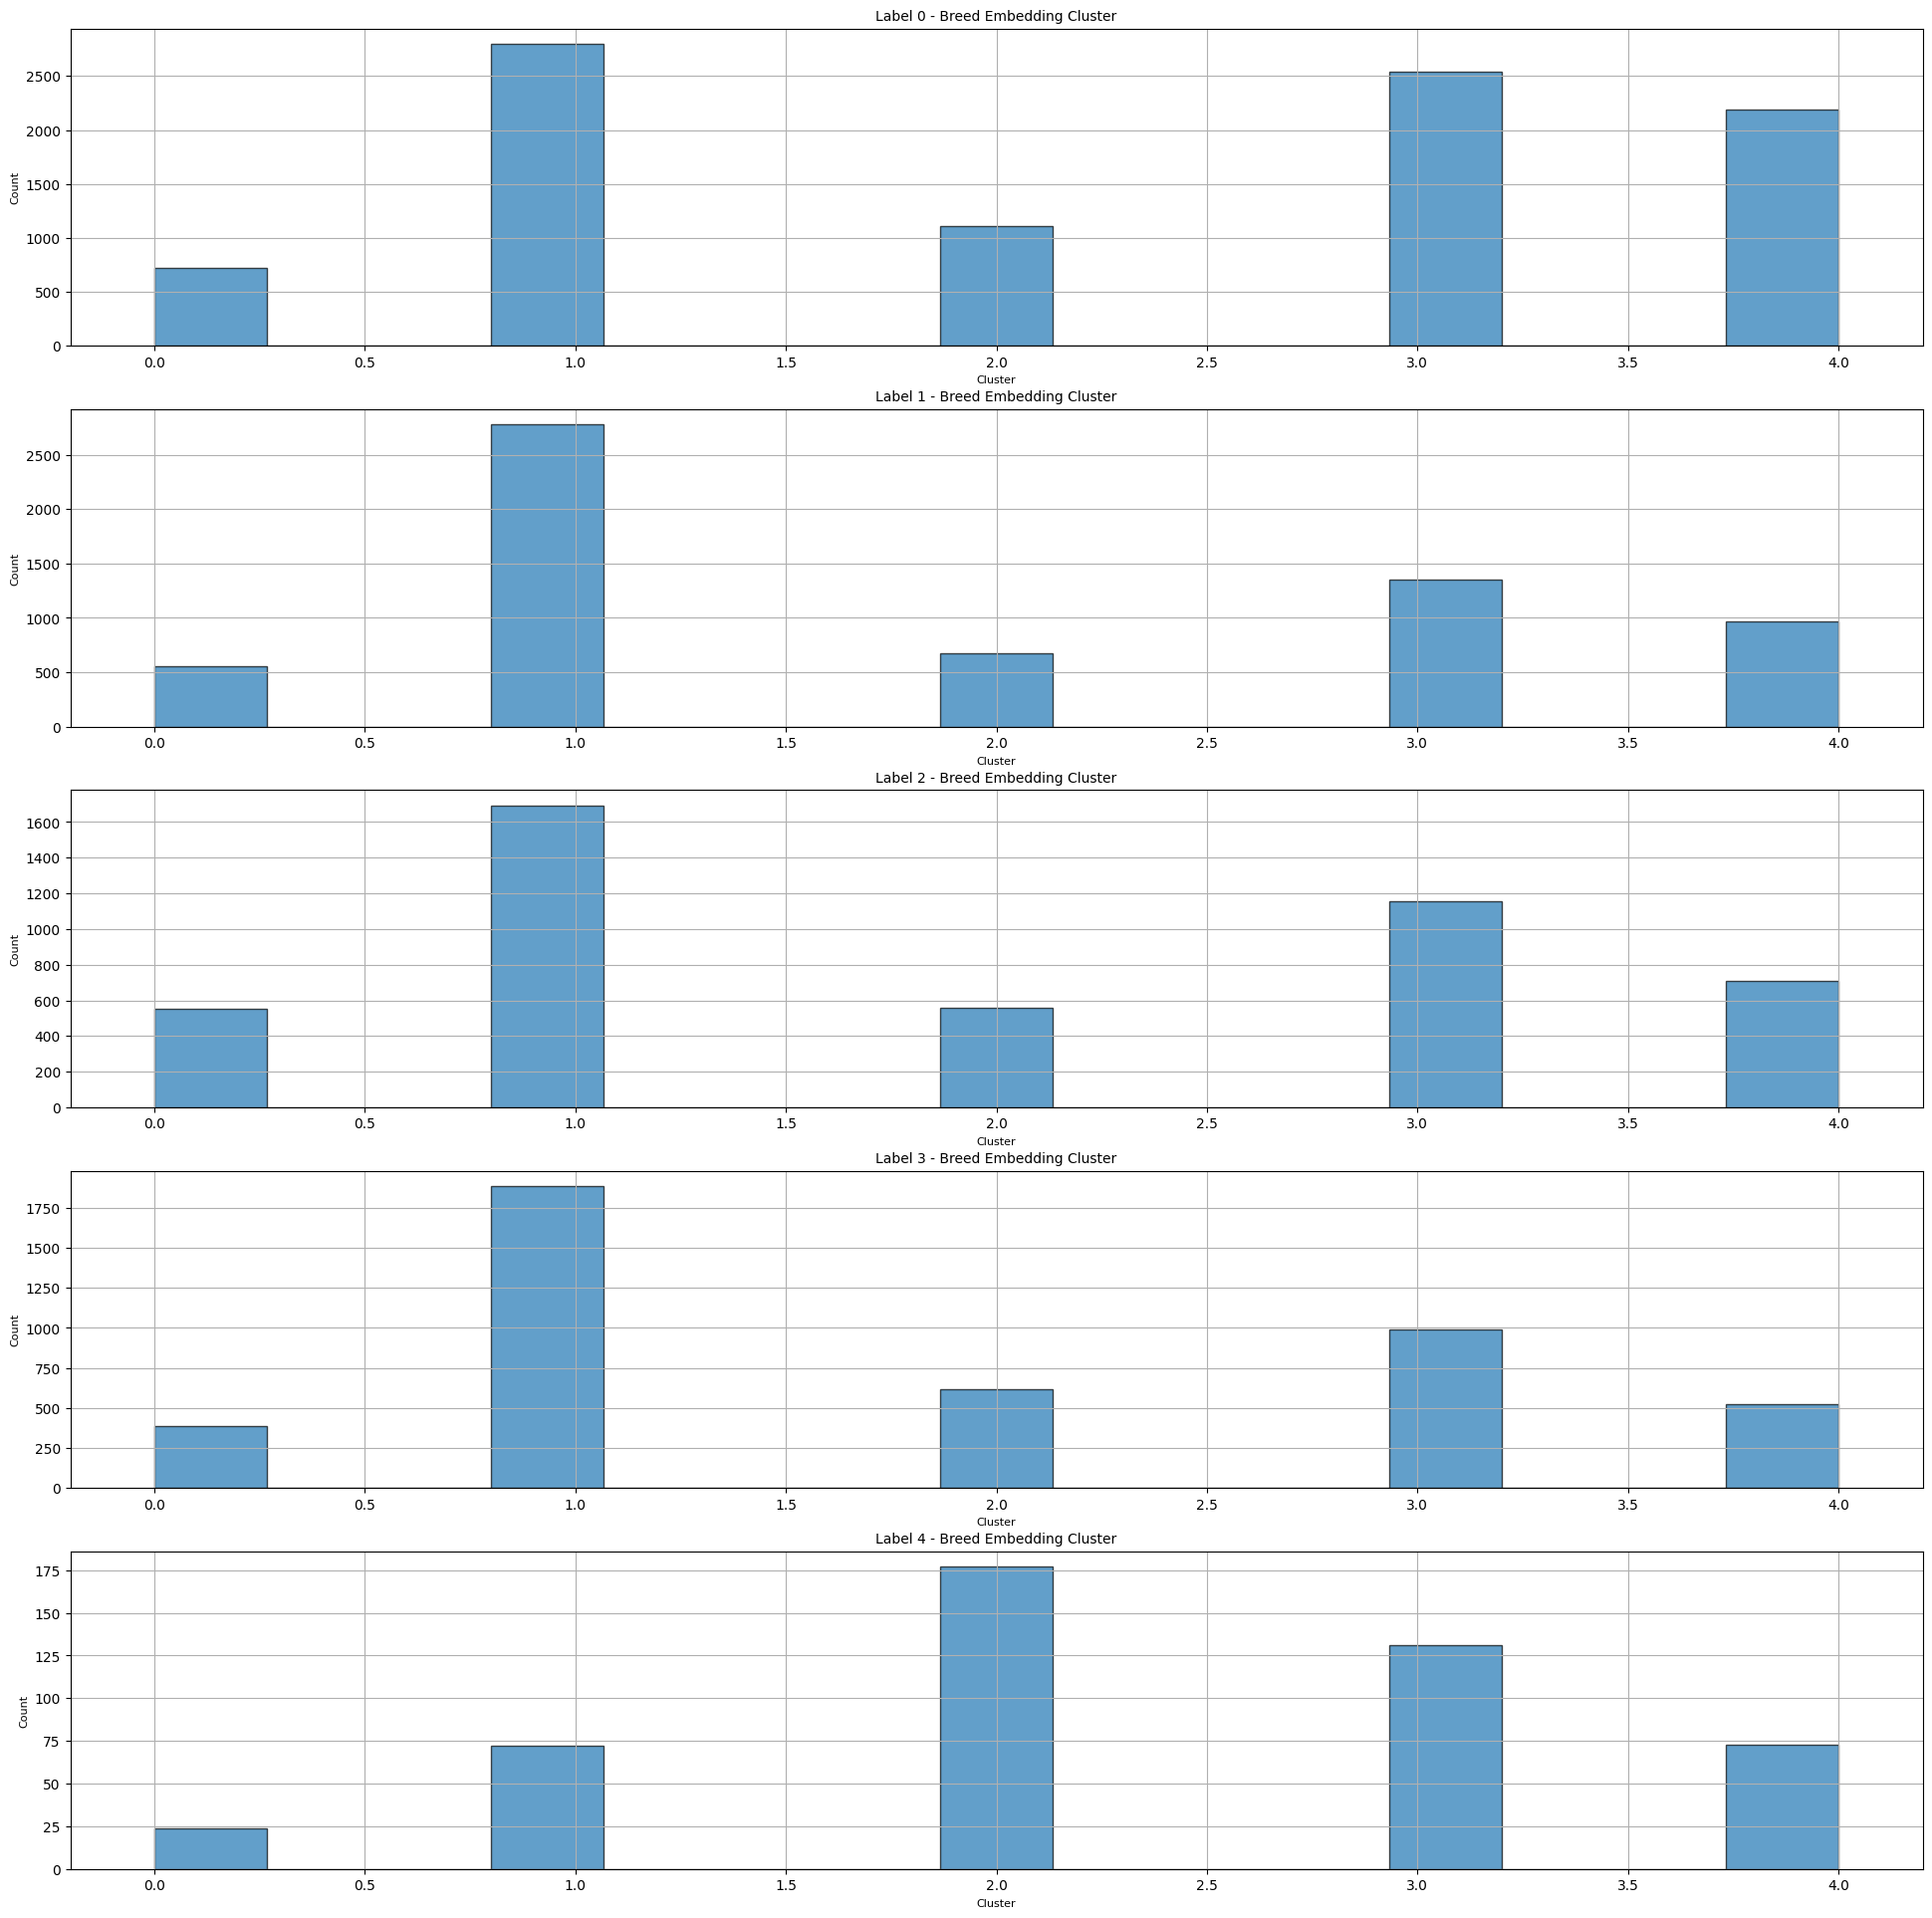

In [ ]:
# Separate df by Days in Shelter Label
df_0 = df[(df['Days_in_Shelter_Label'] == 0)]
df_1 = df[(df['Days_in_Shelter_Label'] == 1)]
df_2 = df[(df['Days_in_Shelter_Label'] == 2)]
df_3 = df[(df['Days_in_Shelter_Label'] == 3)]
df_4 = df[(df['Days_in_Shelter_Label'] == 4)]

# Plot the Age Group distribution for Days in Shelter Label 0
plt.figure(figsize=(24, 24))

plt.subplot(5, 1, 1)
plt.hist(df_0['Breed_Embedding_Cluster'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Label 0 - Breed Embedding Cluster', fontsize=10)
plt.xlabel('Cluster', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)

# Plot the Age Group distribution for Days in Shelter Label 1
plt.subplot(5, 1, 2)
plt.hist(df_1['Breed_Embedding_Cluster'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Label 1 - Breed Embedding Cluster', fontsize=10)
plt.xlabel('Cluster', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)

# Plot the Age Group distribution for Days in Shelter Label 2
plt.subplot(5, 1, 3)
plt.hist(df_2['Breed_Embedding_Cluster'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Label 2 - Breed Embedding Cluster', fontsize=10)
plt.xlabel('Cluster', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)

# Plot the Age Group distribution for Days in Shelter Label 3
plt.subplot(5, 1, 4)
plt.hist(df_3['Breed_Embedding_Cluster'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Label 3 - Breed Embedding Cluster', fontsize=10)
plt.xlabel('Cluster', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)

# Plot the Age Group distribution for Days in Shelter Label 4
plt.subplot(5, 1, 5)
plt.hist(df_4['Breed_Embedding_Cluster'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Label 4 - Breed Embedding Cluster', fontsize=10)
plt.xlabel('Cluster', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)

Age Group Observations

*   Puppy/Kitten age group has the highest representation across days in shelter labels 1-3
*   Days in shelter label 0 most frequent age group is unknown, then adult.
*   Days in shelter label 4 most frequent age group is young
*   All age groups are represented across each days in shelter label
*   Age group unknown is less frequent as the days in shelter label increases






<Axes: xlabel='Days_in_Shelter_Label'>

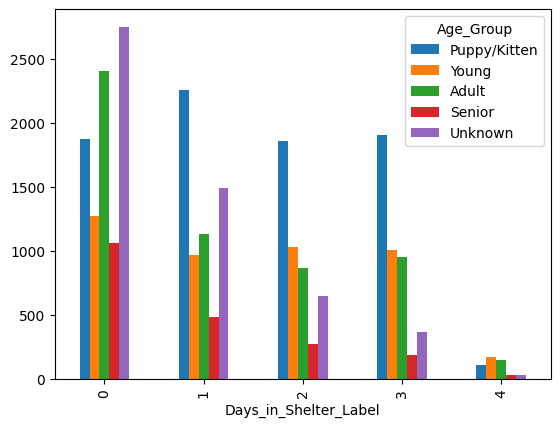

In [ ]:
df.groupby('Age_Group').Days_in_Shelter_Label.value_counts().unstack(0).plot.bar()

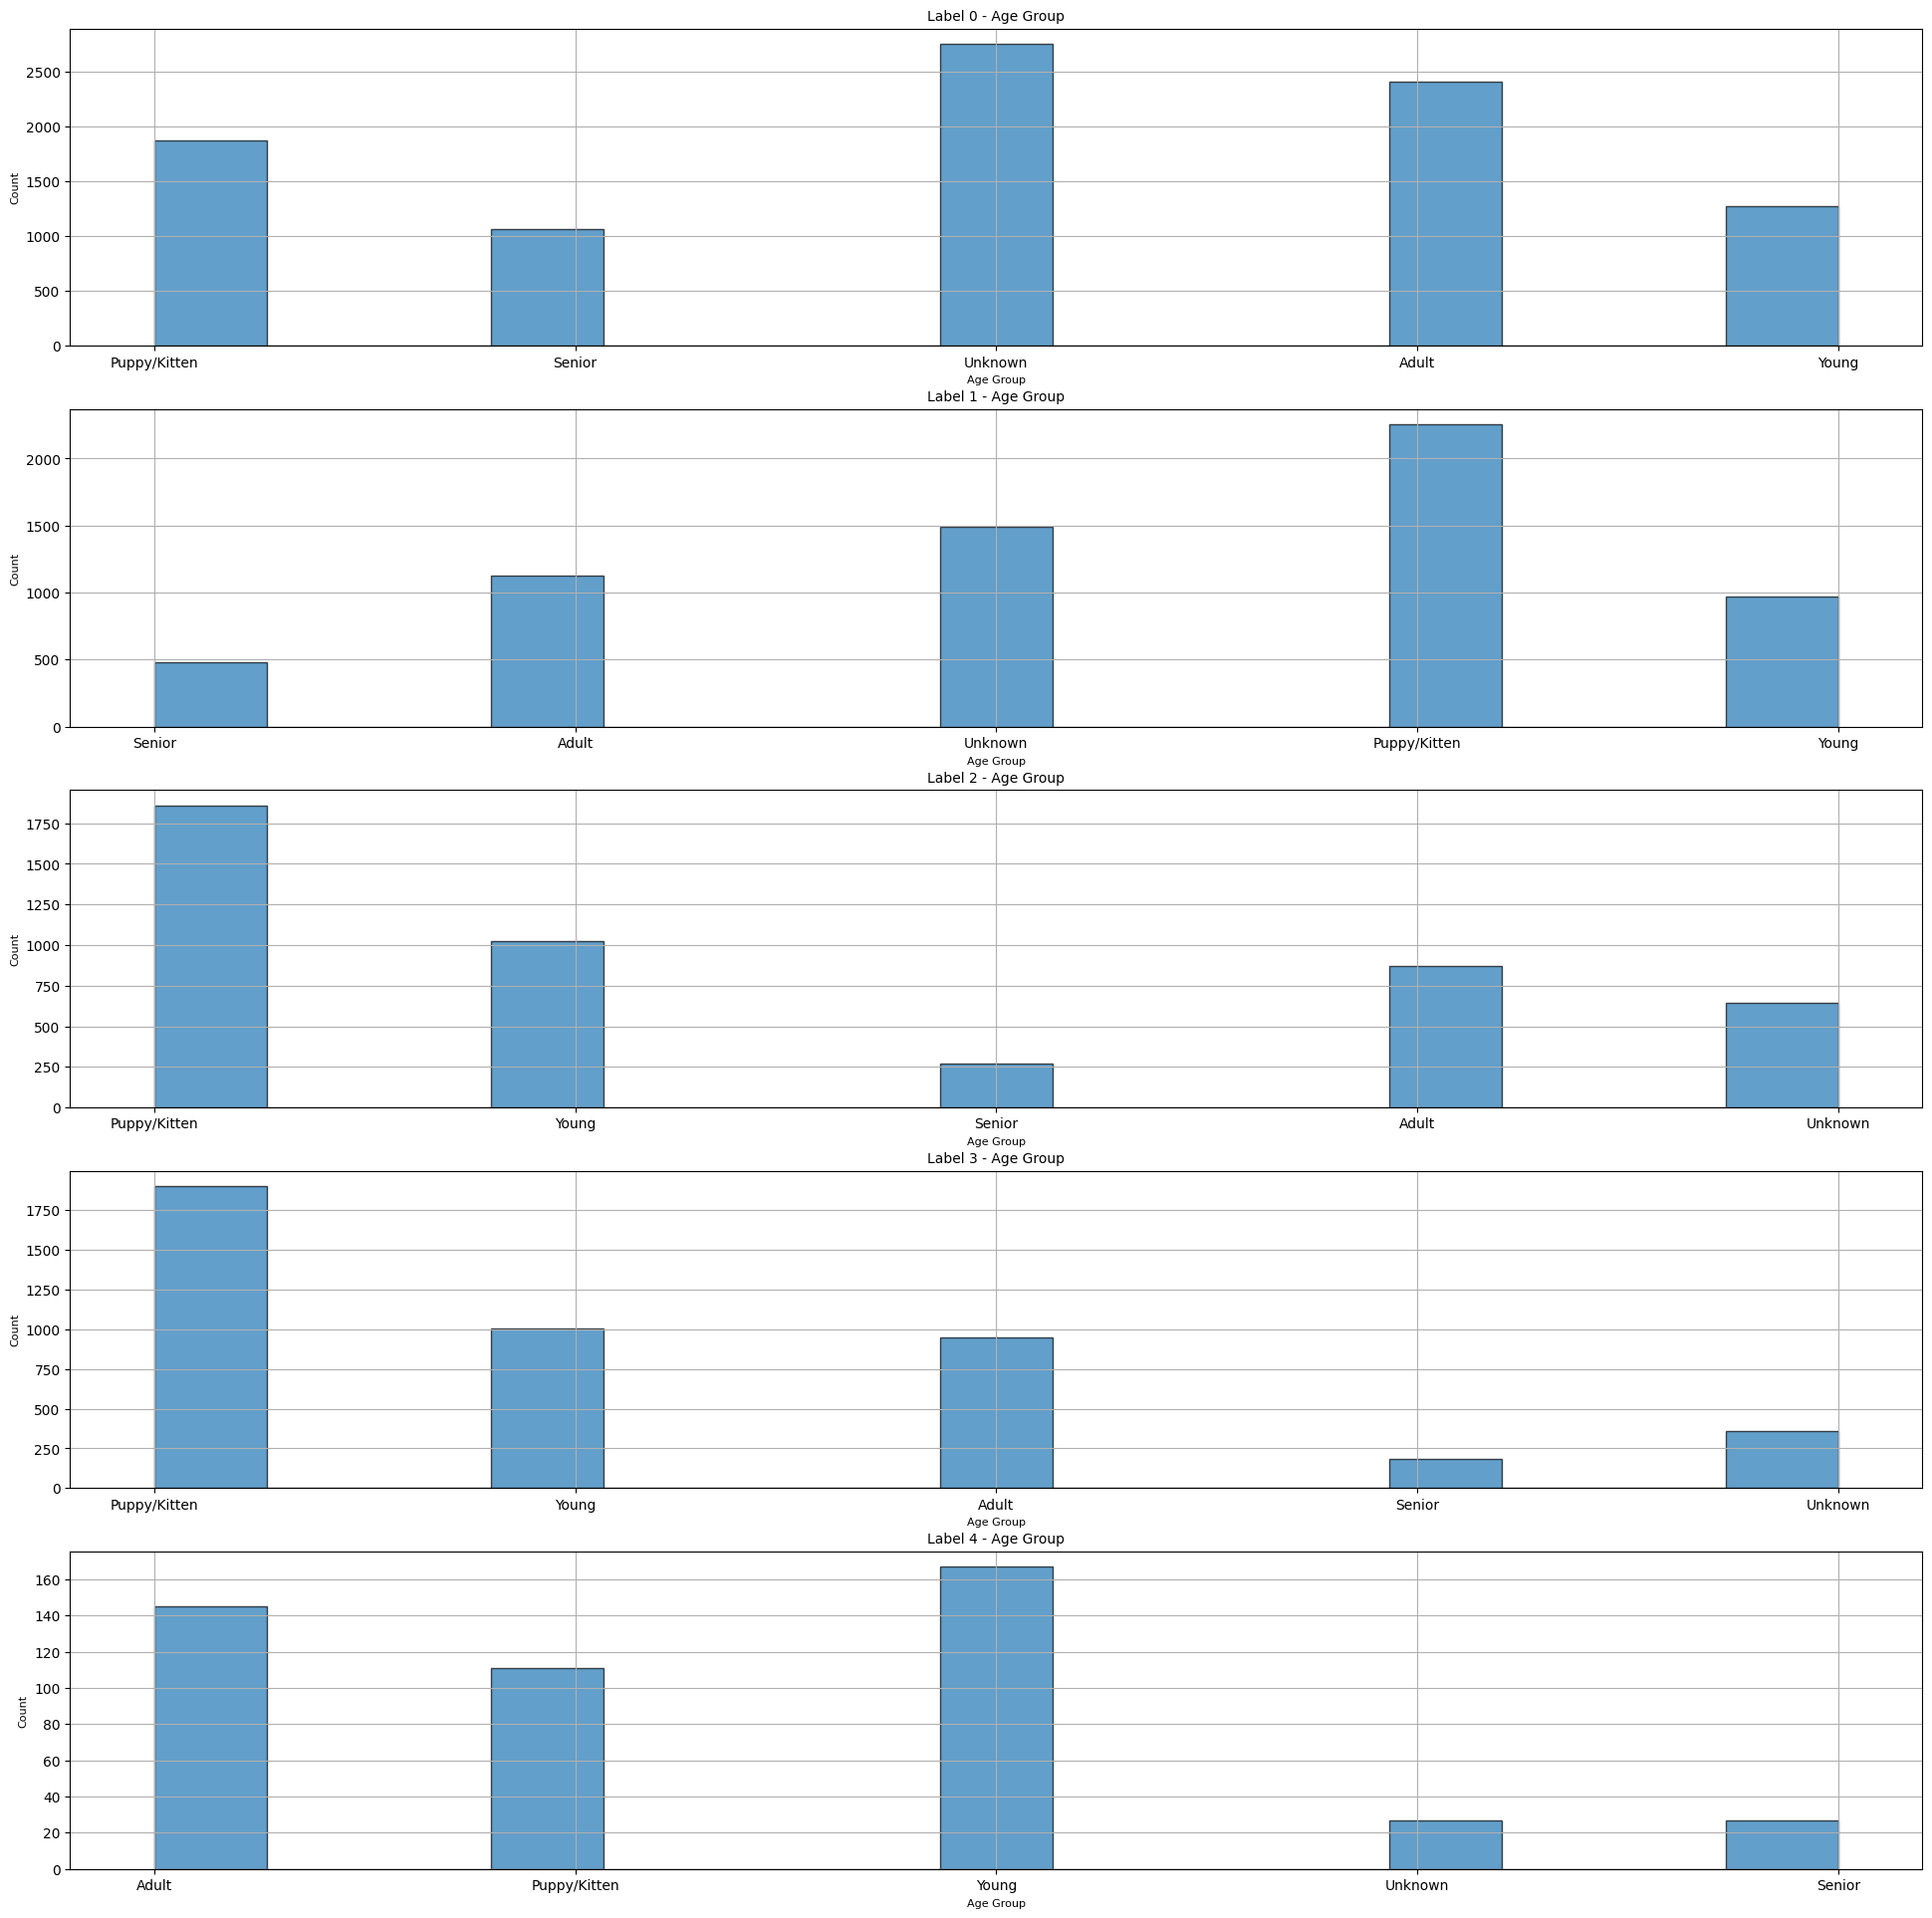

In [ ]:
# Separate df by Days in Shelter Label
df_0 = df[(df['Days_in_Shelter_Label'] == 0)]
df_1 = df[(df['Days_in_Shelter_Label'] == 1)]
df_2 = df[(df['Days_in_Shelter_Label'] == 2)]
df_3 = df[(df['Days_in_Shelter_Label'] == 3)]
df_4 = df[(df['Days_in_Shelter_Label'] == 4)]

# Plot the Age Group distribution for Days in Shelter Label 0
plt.figure(figsize=(24, 24))

plt.subplot(5, 1, 1)
plt.hist(df_0['Age_Group'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Label 0 - Age Group', fontsize=10)
plt.xlabel('Age Group', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)

# Plot the Age Group distribution for Days in Shelter Label 1
plt.subplot(5, 1, 2)
plt.hist(df_1['Age_Group'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Label 1 - Age Group', fontsize=10)
plt.xlabel('Age Group', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)

# Plot the Age Group distribution for Days in Shelter Label 2
plt.subplot(5, 1, 3)
plt.hist(df_2['Age_Group'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Label 2 - Age Group', fontsize=10)
plt.xlabel('Age Group', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)

# Plot the Age Group distribution for Days in Shelter Label 3
plt.subplot(5, 1, 4)
plt.hist(df_3['Age_Group'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Label 3 - Age Group', fontsize=10)
plt.xlabel('Age Group', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)

# Plot the Age Group distribution for Days in Shelter Label 4
plt.subplot(5, 1, 5)
plt.hist(df_4['Age_Group'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Label 4 - Age Group', fontsize=10)
plt.xlabel('Age Group', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)

Intake Type Observations

*   Stray is the most frequent intake type across all days in shelter labels
*   A higher porportion of confiscate and owner surrender intake types are represented in days in shelter label 4



<Axes: xlabel='Days_in_Shelter_Label'>

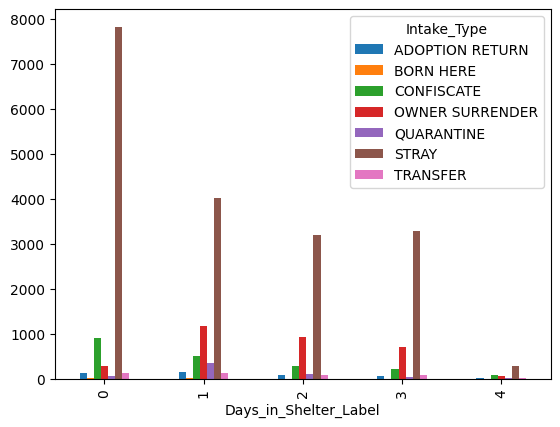

In [ ]:
df.groupby('Intake_Type').Days_in_Shelter_Label.value_counts().unstack(0).plot.bar()

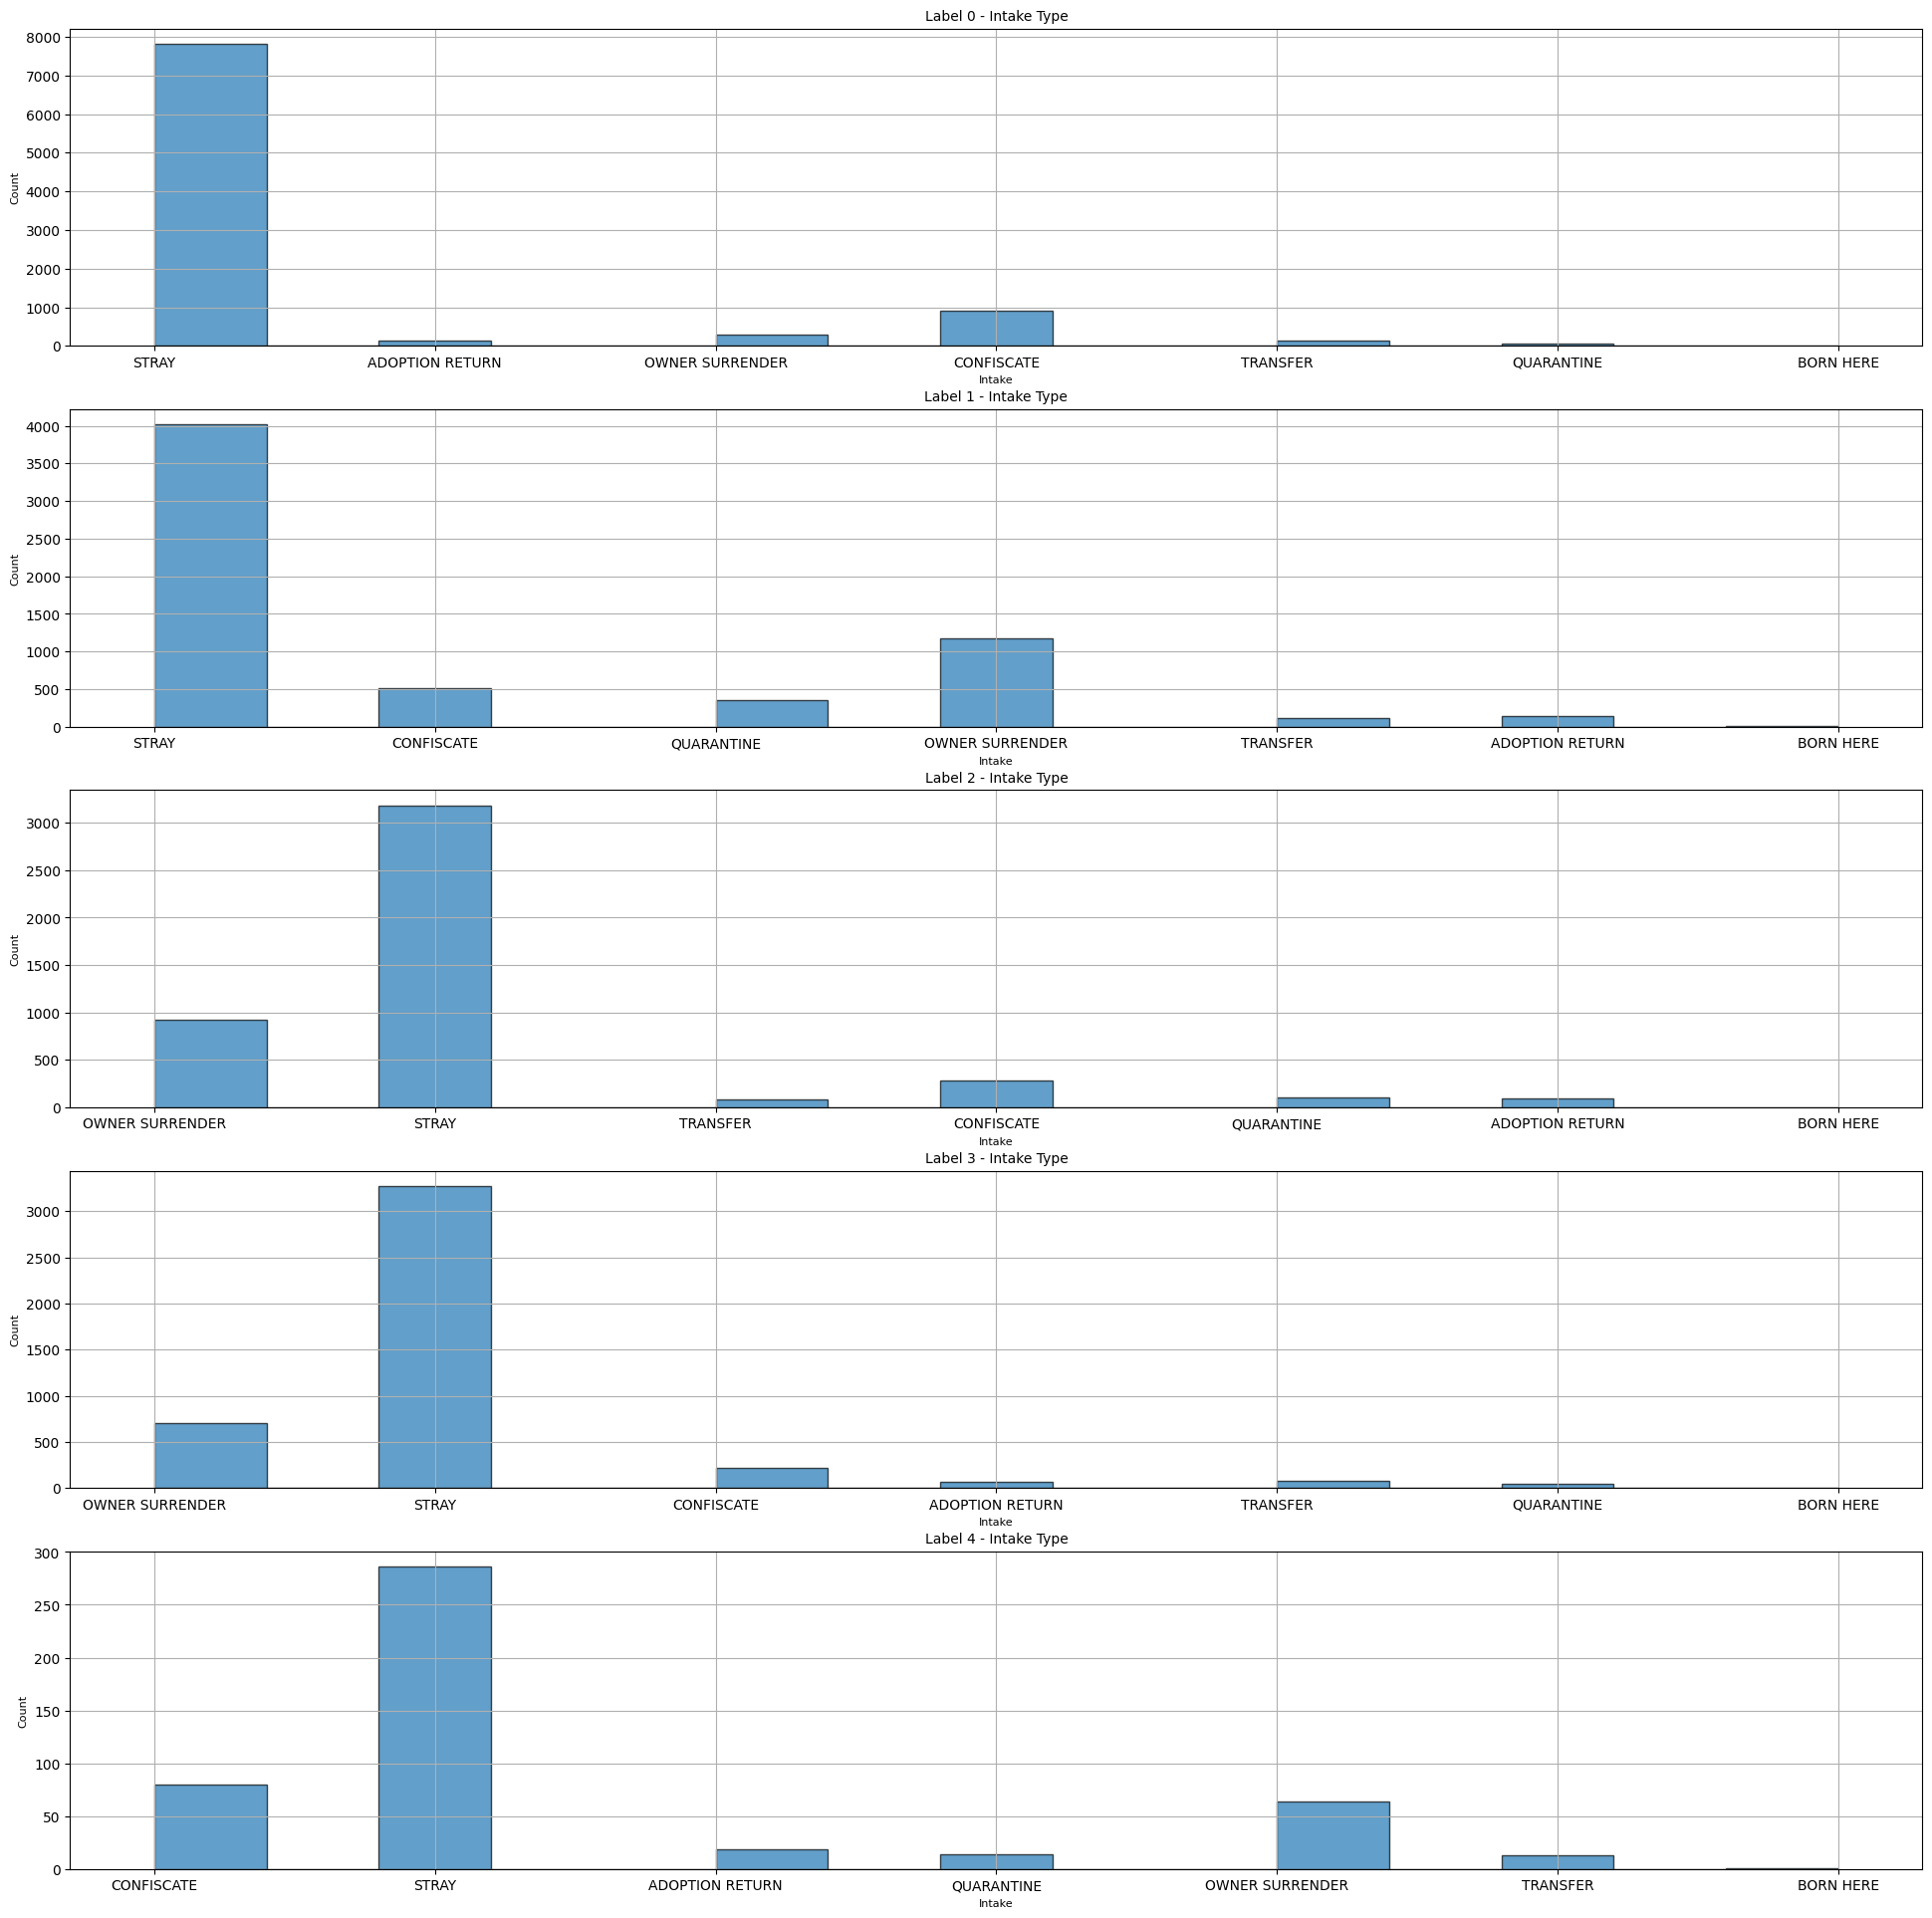

In [ ]:
# Separate df by Days in Shelter Label
df_0 = df[(df['Days_in_Shelter_Label'] == 0)]
df_1 = df[(df['Days_in_Shelter_Label'] == 1)]
df_2 = df[(df['Days_in_Shelter_Label'] == 2)]
df_3 = df[(df['Days_in_Shelter_Label'] == 3)]
df_4 = df[(df['Days_in_Shelter_Label'] == 4)]

# Plot the Intake Type distribution for Days in Shelter Label 0
plt.figure(figsize=(24, 24))

plt.subplot(5, 1, 1)
plt.hist(df_0['Intake_Type'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Label 0 - Intake Type', fontsize=10)
plt.xlabel('Intake', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)

# Plot the Intake Type distribution for Days in Shelter Label 1
plt.subplot(5, 1, 2)
plt.hist(df_1['Intake_Type'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Label 1 - Intake Type', fontsize=10)
plt.xlabel('Intake', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)

# Plot the Intake Type distribution for Days in Shelter Label 2
plt.subplot(5, 1, 3)
plt.hist(df_2['Intake_Type'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Label 2 - Intake Type', fontsize=10)
plt.xlabel('Intake', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)

# Plot the Intake Type distribution for Days in Shelter Label 3
plt.subplot(5, 1, 4)
plt.hist(df_3['Intake_Type'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Label 3 - Intake Type', fontsize=10)
plt.xlabel('Intake', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)

# Plot the Intake Type distribution for Days in Shelter Label 4
plt.subplot(5, 1, 5)
plt.hist(df_4['Intake_Type'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Label 4 - Intake Type', fontsize=10)
plt.xlabel('Intake', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)

Intake Condition Observations

*   Healthy is the most common intake condition for days in shelter label 1-4
*   Unknown is the most common intake condition for days in shelter label 0 by a few 100s of records. Healthy is the second most comment condition

<Axes: xlabel='Days_in_Shelter_Label'>

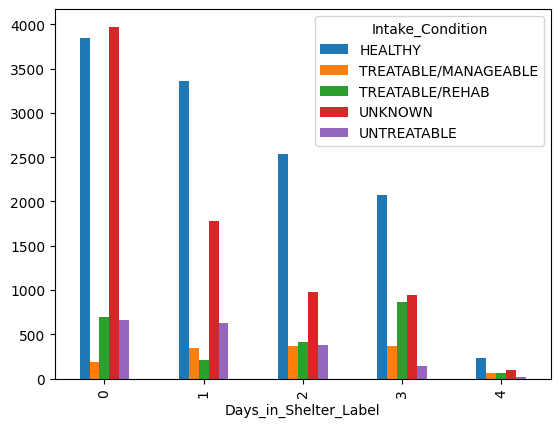

In [ ]:
df.groupby('Intake_Condition').Days_in_Shelter_Label.value_counts().unstack(0).plot.bar()

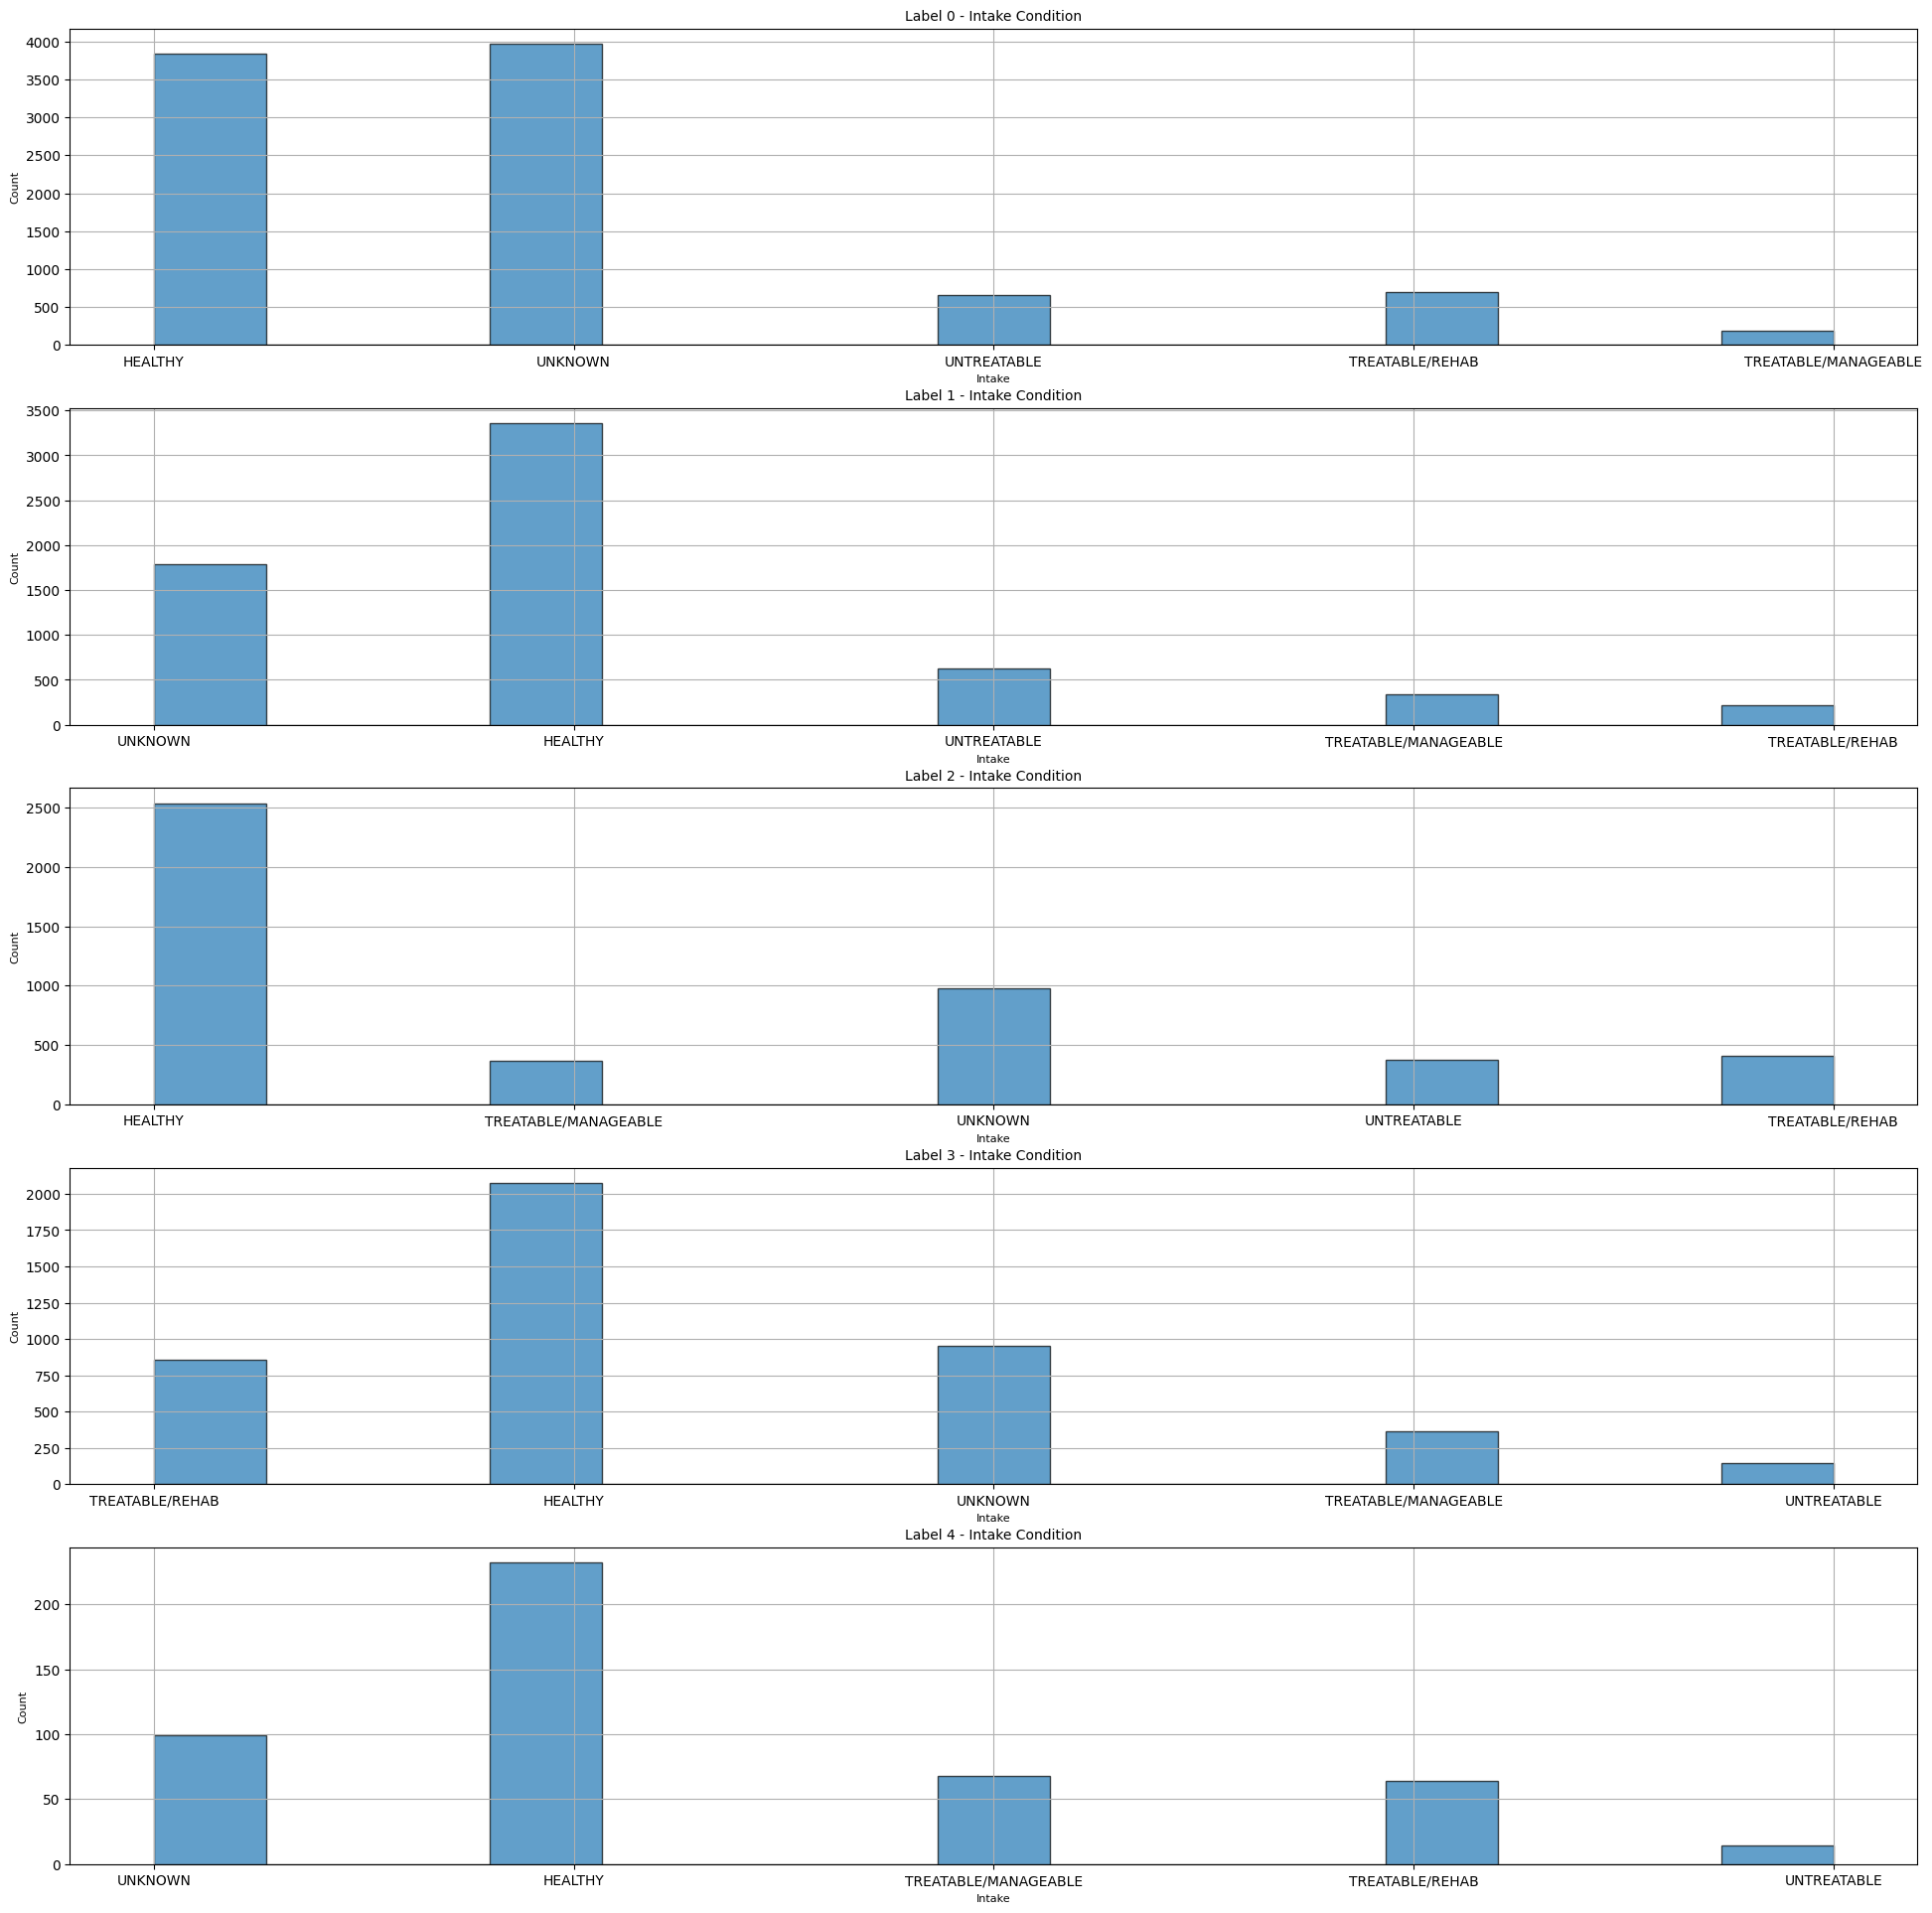

In [ ]:
# Separate df by Days in Shelter Label
df_0 = df[(df['Days_in_Shelter_Label'] == 0)]
df_1 = df[(df['Days_in_Shelter_Label'] == 1)]
df_2 = df[(df['Days_in_Shelter_Label'] == 2)]
df_3 = df[(df['Days_in_Shelter_Label'] == 3)]
df_4 = df[(df['Days_in_Shelter_Label'] == 4)]

# Plot the Intake Type distribution for Days in Shelter Label 0
plt.figure(figsize=(24, 24))

plt.subplot(5, 1, 1)
plt.hist(df_0['Intake_Condition'].dropna(), bins= 15, edgecolor='k', alpha=0.7)
plt.title('Label 0 - Intake Condition', fontsize=10)
plt.xlabel('Intake', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)

# Plot the Intake Type distribution for Days in Shelter Label 1
plt.subplot(5, 1, 2)
plt.hist(df_1['Intake_Condition'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Label 1 - Intake Condition', fontsize=10)
plt.xlabel('Intake', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)

# Plot the Intake Type distribution for Days in Shelter Label 2
plt.subplot(5, 1, 3)
plt.hist(df_2['Intake_Condition'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Label 2 - Intake Condition', fontsize=10)
plt.xlabel('Intake', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)

# Plot the Intake Type distribution for Days in Shelter Label 3
plt.subplot(5, 1, 4)
plt.hist(df_3['Intake_Condition'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Label 3 - Intake Condition', fontsize=10)
plt.xlabel('Intake', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)

# Plot the Intake Type distribution for Days in Shelter Label 4
plt.subplot(5, 1, 5)
plt.hist(df_4['Intake_Condition'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Label 4 - Intake Condition', fontsize=10)
plt.xlabel('Intake', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)

Outcome Condition Observations

*   Healthy is the most common outcome condition across all days in shelter labels
*   Pending becomes a less frequent condition as the days in shelter labels increase



<Axes: xlabel='Days_in_Shelter_Label'>

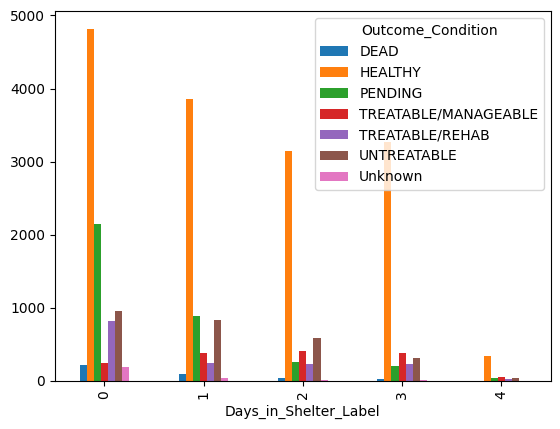

In [ ]:
df.groupby('Outcome_Condition').Days_in_Shelter_Label.value_counts().unstack(0).plot.bar()

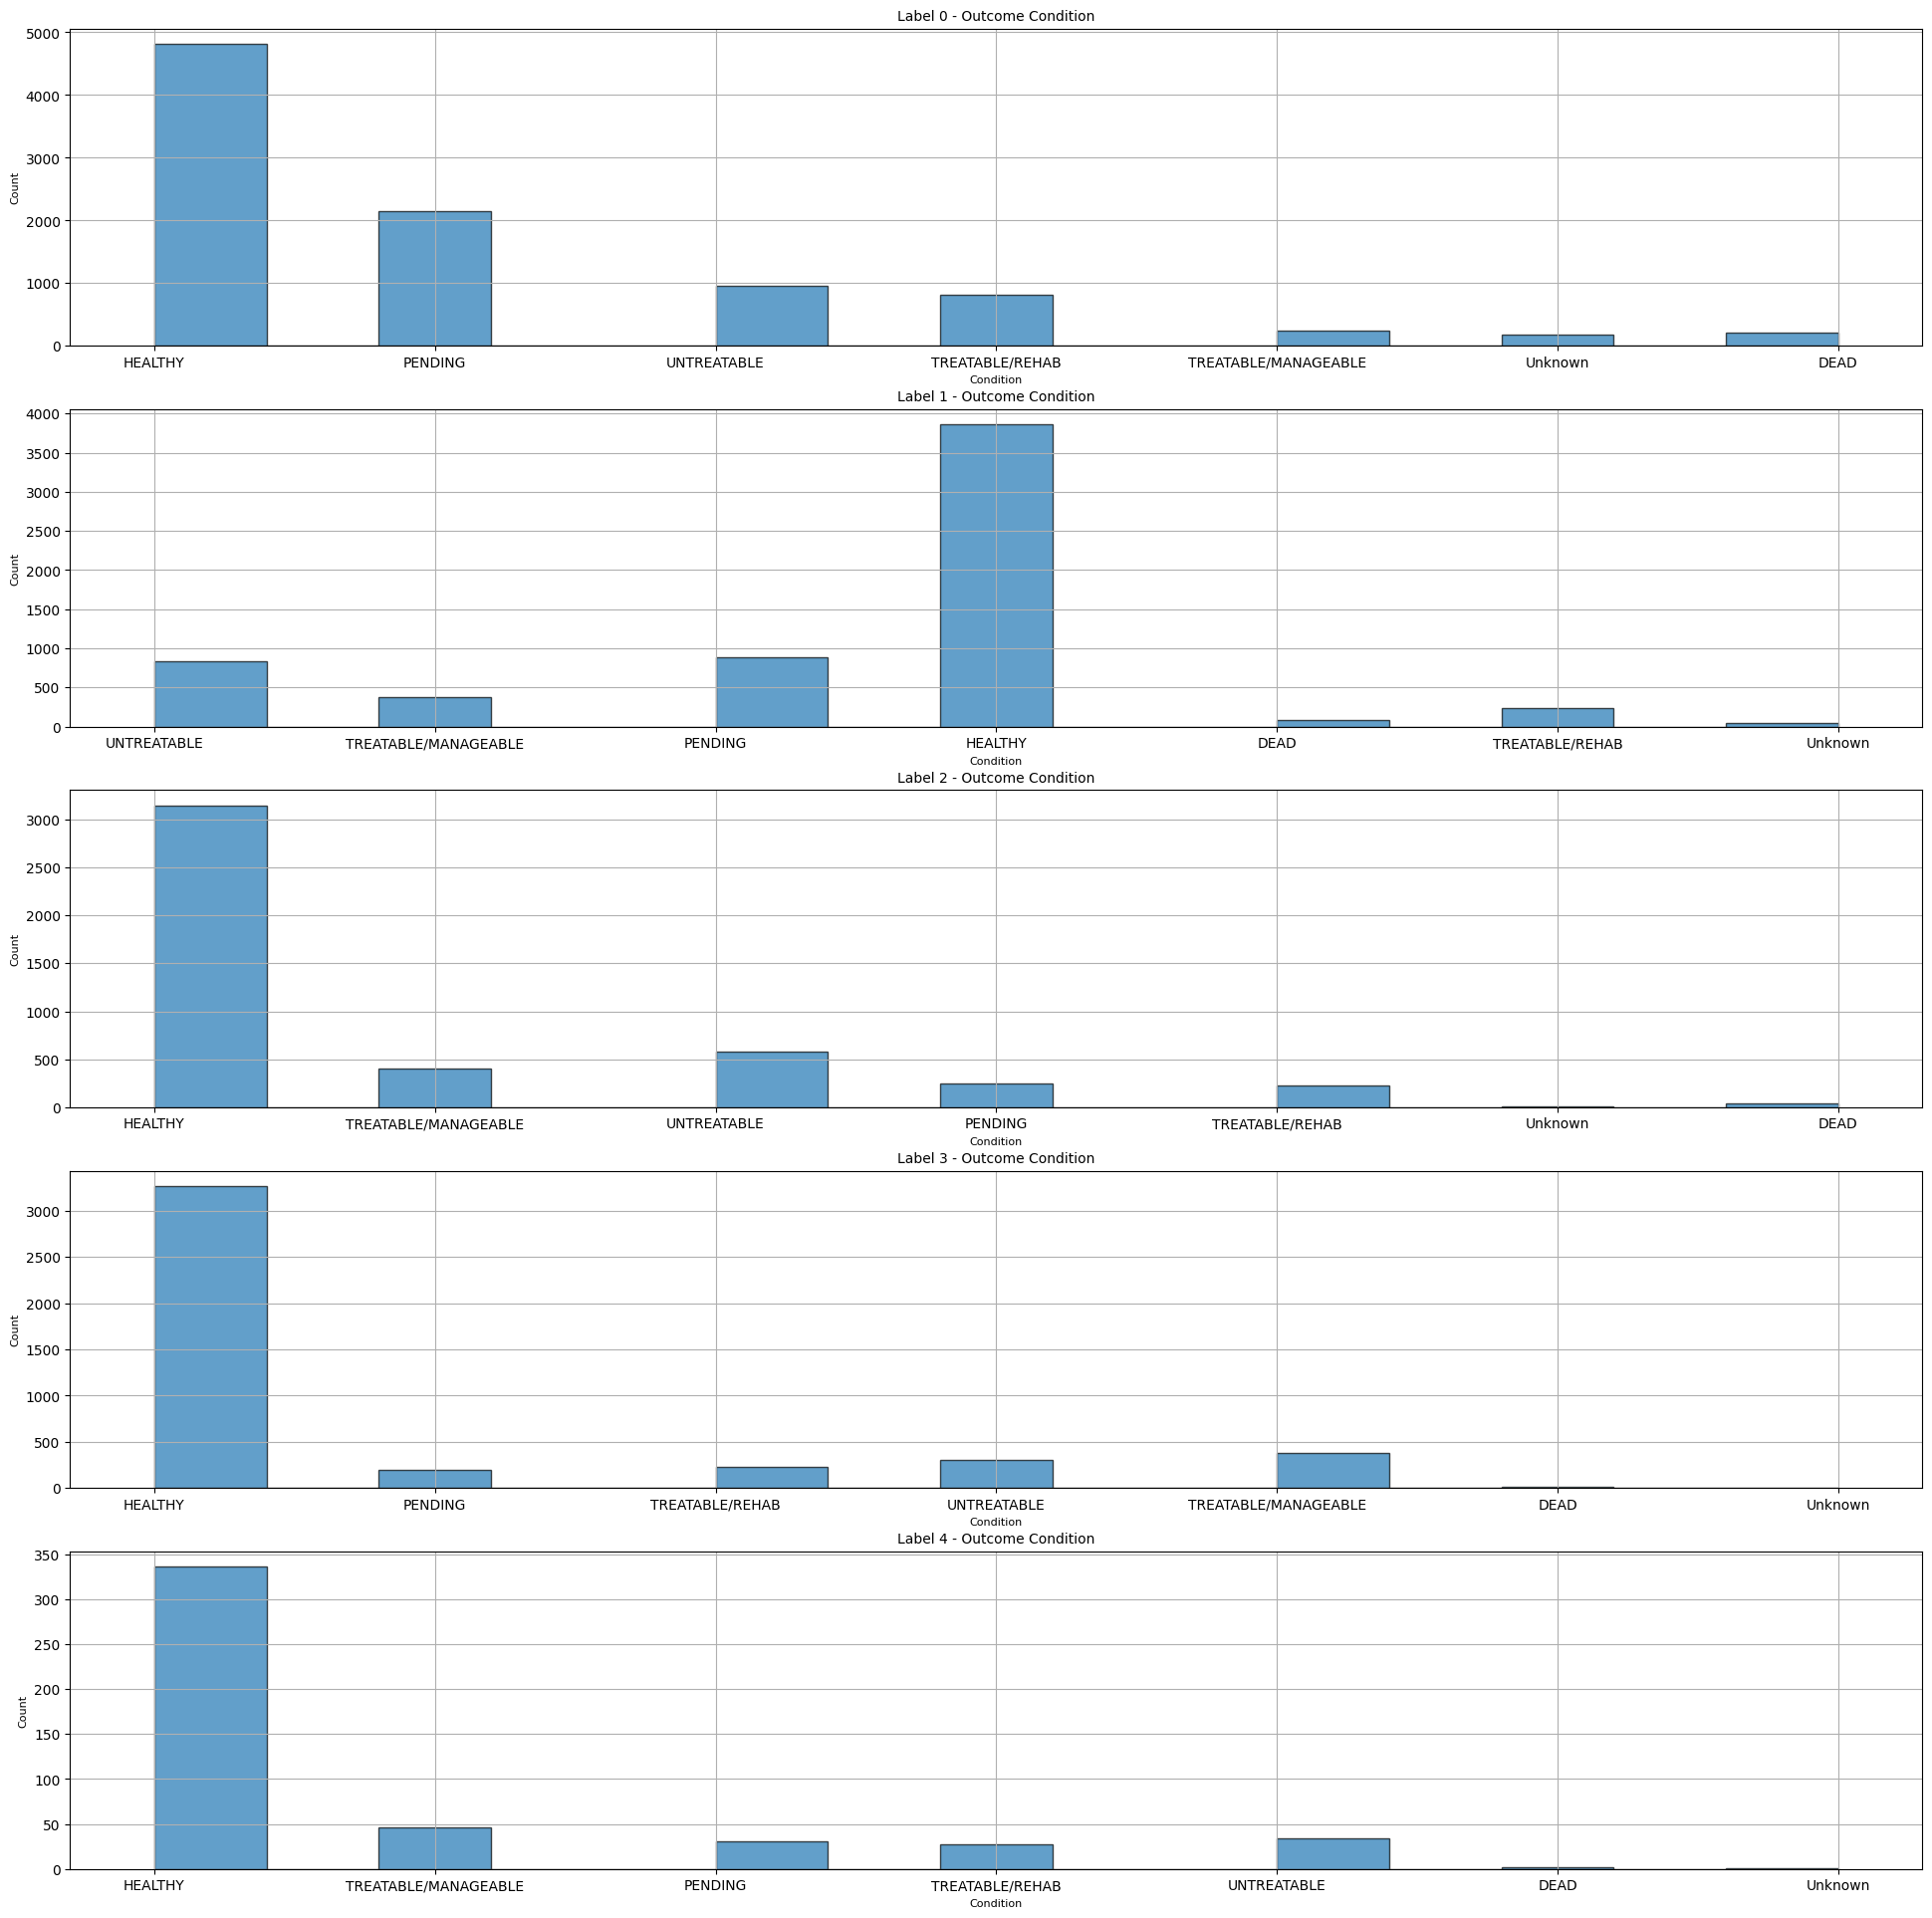

In [ ]:
# Separate df by Days in Shelter Label
df_0 = df[(df['Days_in_Shelter_Label'] == 0)]
df_1 = df[(df['Days_in_Shelter_Label'] == 1)]
df_2 = df[(df['Days_in_Shelter_Label'] == 2)]
df_3 = df[(df['Days_in_Shelter_Label'] == 3)]
df_4 = df[(df['Days_in_Shelter_Label'] == 4)]

# Plot the Outcome Condition distribution for Days in Shelter Label 0
plt.figure(figsize=(24, 24))

plt.subplot(5, 1, 1)
plt.hist(df_0['Outcome_Condition'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Label 0 - Outcome Condition', fontsize=10)
plt.xlabel('Condition', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)

# Plot the Outcome Condition distribution for Days in Shelter Label 1
plt.subplot(5, 1, 2)
plt.hist(df_1['Outcome_Condition'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Label 1 - Outcome Condition', fontsize=10)
plt.xlabel('Condition', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)

# Plot the Outcome Condition distribution for Days in Shelter Label 2
plt.subplot(5, 1, 3)
plt.hist(df_2['Outcome_Condition'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Label 2 - Outcome Condition', fontsize=10)
plt.xlabel('Condition', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)

# Plot the Outcome Condition distribution for Days in Shelter Label 3
plt.subplot(5, 1, 4)
plt.hist(df_3['Outcome_Condition'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Label 3 - Outcome Condition', fontsize=10)
plt.xlabel('Condition', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)

# Plot the Outcome Condition distribution for Days in Shelter Label 4
plt.subplot(5, 1, 5)
plt.hist(df_4['Outcome_Condition'].dropna(), bins=15, edgecolor='k', alpha=0.7)
plt.title('Label 4 - Outcome Condition', fontsize=10)
plt.xlabel('Condition', fontsize=8)
plt.ylabel('Count', fontsize=8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)